<a href="https://colab.research.google.com/github/MeenakshiRajpurohit/Website_Trafffic_Data_Analysis_EDA/blob/main/eda_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EDA Step One – Understand Problem & Data



# EDA Step 1: Understand Problem & Data

This foundational step establishes the strategic context, research goals, and the initial quality assessment of the chosen dataset, ensuring that all subsequent analysis is relevant and targeted.

---

## 1. Business Goal and Problem Definition

The overarching business objective of this exploratory data project is to understand **user engagement and conversion dynamics** on the website in order to generate actionable business intelligence that can optimize marketing spend and improve website performance.

Core Problem: To move beyond simple descriptive statistics and identify distinct user behavior patterns (e.g., highly engaged vs. low-intent users), evaluate how different Traffic Sources contribute to the unusually high Conversion Rate, and determine actionable factors (such as Traffic Source and session characteristics) that drive high engagement and conversions—ultimately informing marketing strategy and improving return on investment (ROI).




### B. Key Performance Questions:
The analysis is structured to answer high-value business questions:

- Which traffic sources (e.g., Organic, Paid, Social) generate the most valuable, high-converting users?
- How do session engagement metrics (Session Duration, Time on Page) interact with user outcomes (Conversion Rate)?
- What distinct behavioral patterns separate high-engagement sessions from low-engagement sessions?

---

## 2. Dataset Selection and Description

The **Website Traffic Descriptive Statistics dataset** was selected due to its high potential for generating immediate, actionable business intelligence.

### A. Dataset Rationale:

- **Actionability:** Contains critical metrics like Conversion Rate and Bounce Rate which directly measure business success.
- **Data Mix:** Includes a mix of essential numerical variables and the crucial categorical variable, Traffic Source, allowing for powerful segmentation analysis.
- **Quality:** The dataset is clean, consisting of 2,000 entries with no apparent missing values, enabling immediate analysis.

### B. Main Variables:
The dataset features metrics describing user engagement, loyalty, and outcome:

| Variable | Description | Type |
|----------|-------------|------|
| **Page Views** | Number of pages visited per session. | Numerical (Count) |
| **Session Duration** | Total time spent on the site per session (in minutes). | Numerical (Time) |
| **Time on Page** | Focused time spent on a specific page (in minutes). | Numerical (Time) |
| **Bounce Rate** | Probability (0 to 1) that the user leaves after viewing only one page. | Numerical (Ratio) |
| **Previous Visits** | Number of times the user has visited the site prior to this session. | Numerical (Count) |
| **Conversion Rate** | Probability (0 to 1) that the session resulted in a successful conversion. | Numerical (Ratio) |
| **Traffic Source** | The channel the user arrived from (e.g., Organic, Paid, Direct, Social). | Categorical |

---

## 3. Initial Research Questions

The following questions will guide the analysis in Steps 4 through 7:

| Research Question | Focus |
|-------------------|-------|
| **Performance by Source** | How do key metrics (Conversion Rate, Bounce Rate, Session Duration) compare across the different Traffic Sources? |
| **Loyalty and Conversion** | Does the number of Previous Visits correlate positively with higher Page Views and a better Conversion Rate? |
| **Impact of Time** | What is the specific relationship between Time on Page and the final Conversion Rate? |
| **Outlier Profiling** | What is the profile (Traffic Source, Previous Visits) of the sessions that fall into the upper quartiles for Session Duration (high-engagement outliers)? |

---

## 4. Initial Data Characteristics (Insights from Descriptive Statistics)

A preliminary review of the means, medians, and modes immediately highlights characteristics and anomalies that must be addressed through transformation and segmentation.

| Characteristic | Metric & Value | Implication for Further EDA |
|----------------|----------------|------------------------------|
| **Conversion Anomaly** | Conversion Rate (Mean: 98.2%, Mode/Median: 1.0) | The dataset is heavily concentrated on successful conversions. This extreme result suggests the data may be filtered for high-intent users or is highly targeted. The focus must be on profiling the minority non-converting group (≈ 1.8%). |
| **Engagement Skew** | Session Duration (Mean: 3.02 min, Median: 2.0 min) | The Mean > Median indicates a strong right-skewness in time metrics. Most sessions are short, but a few high-duration sessions (up to 20.3 min) inflate the average. This necessitates logarithmic transformation (Step 5) and outlier-based feature engineering (Step 7). |
| **User Loyalty** | Previous Visits (Mean, Median, Mode ≈ 2.0) | The user base is predominantly returning visitors. Since loyalty is the norm, conversion drivers are likely tied to session quality (duration, page views) rather than just the number of visits. |
| **Initial Bounce** | Bounce Rate (Average: 28.5%) | Indicates a generally acceptable level of initial engagement, providing a stable baseline for comparative analysis against Traffic Sources. |

---

## Conclusion of Step 1

The data is structurally sound and directly relevant to the business goal. The key challenges identified are the extreme skewness of time metrics and the anomaly of the high conversion rate, which will drive the feature engineering and segmentation strategy in the subsequent steps.

---

In [ ]:
import pandas as pd
import numpy as np

# Define the file name for the uploaded Website Traffic dataset
FILE_NAME = "/content/Website Traffic export 2025-10-14 19-32-50.csv"

# ==============================================================================
# 1. Load Data and Initial Inspection
#    (Objective: Load data without errors/truncations and check size)
# ==============================================================================
print("--- 1. Data Loading and Structural Review ---")
try:
    # Read the CSV. The data is enclosed in quotes, so we use string replacement
    # to clean up the data *before* type conversion is attempted.
    df = pd.read_csv(FILE_NAME)

    # Clean the column names by stripping leading/trailing quotes and spaces
    df.columns = df.columns.str.strip().str.replace('"', '')

    # Clean all string data in the DataFrame by removing quotes
    df = df.replace('"', '', regex=True)

    print(f"✅ Data loaded successfully from '{FILE_NAME}'.")

    # Check the size of the data (number of rows and columns)
    num_rows, num_cols = df.shape
    print(f"Data Shape: ({num_rows}, {num_cols})")
    print(f"Total Records: {num_rows} | Total Features: {num_cols}")

except FileNotFoundError:
    print(f"❌ Error: File '{FILE_NAME}' not found. Please check the file name.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()


# ==============================================================================
# 2. Check for Missing Values
#    (Objective: Identify data completeness)
# ==============================================================================
print("\n--- 2. Missing Value Check ---")
missing_check = df.isnull().sum()
if missing_check.sum() == 0:
    print("✅ Conclusion: No missing values found in the dataset. Excellent data quality!")
else:
    print("⚠️ Missing values found. Counts per column:")
    print(missing_check[missing_check > 0])


# ==============================================================================
# 3. Identify Data Types and Initial Cleaning
#    (Objective: Verify data types and prepare for statistical summary)
# ==============================================================================
print("\n--- 3. Data Type Validation and Cleaning ---")
print("Initial Data Types:")
print(df.dtypes)

# Convert numerical columns from object (string) type to float/int
# This is necessary because the initial CSV read may treat all quoted numbers as strings
numerical_cols = ['Page Views', 'Session Duration', 'Bounce Rate', 'Time on Page', 'Previous Visits', 'Conversion Rate']
for col in numerical_cols:
    try:
        # We need to coerce errors in case of non-numeric data, though not expected here
        if col in ['Page Views', 'Previous Visits']:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64') # Use Int64 for nullable integer
        else:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    except Exception as e:
        print(f"Error converting column {col}: {e}")

print("\nFinal Data Types (after conversion):")
print(df.dtypes)

# ==============================================================================
# 4. Look for Errors, Inconsistencies, and Descriptive Statistics
#    (Objective: Identify outliers, skewness, and measure central tendency)
# ==============================================================================
print("\n--- 4. Data Consistency and Statistical Summary ---")

# Check unique values for the categorical column 'Traffic Source'
print("Categorical Feature Unique Values:")
print(df['Traffic Source'].value_counts())

# Generate descriptive statistics for numerical columns
desc_stats = df[numerical_cols].describe().T
print("\nDescriptive Statistics (Inconsistencies/Outlier Indicators):")
print(desc_stats)

# Analyze for Key Inconsistencies (based on the descriptive stats)
print("\nKey Insights from Descriptive Statistics:")

# Check for zero Page Views or very short Session Duration (potential high bounces/errors)
zero_page_views = df[df['Page Views'] == 0].shape[0]
print(f"- Sessions with 0 Page Views: {zero_page_views} rows")

# Check for skewness (Mean > Median often indicates right-skew/outliers)
# Session Duration and Time on Page are often skewed in web data
mean_duration = desc_stats.loc['Session Duration', 'mean']
median_duration = desc_stats.loc['Session Duration', '50%']
print(f"- Session Duration Skew: Mean ({mean_duration:.2f}) > Median ({median_duration:.2f}) -> Right-skew confirmed (potential long-session outliers).")

# Check Conversion Rate anomaly (confirmed from the data inspection)
mean_conversion = desc_stats.loc['Conversion Rate', 'mean']
print(f"- Conversion Anomaly: Mean Conversion Rate is {mean_conversion:.3f} (near 1.0), requiring focus on the non-converting minority.")

# Display the first few rows with cleaned/converted data
print("\nCleaned Data Preview (Head):")
print(df.head())

--- 1. Data Loading and Structural Review ---
✅ Data loaded successfully from '/content/Website Traffic export 2025-10-14 19-32-50.csv'.
Data Shape: (2000, 7)
Total Records: 2000 | Total Features: 7

--- 2. Missing Value Check ---
✅ Conclusion: No missing values found in the dataset. Excellent data quality!

--- 3. Data Type Validation and Cleaning ---
Initial Data Types:
Page Views            int64
Session Duration    float64
Bounce Rate         float64
Traffic Source       object
Time on Page        float64
Previous Visits       int64
Conversion Rate     float64
dtype: object

Final Data Types (after conversion):
Page Views            Int64
Session Duration    float64
Bounce Rate         float64
Traffic Source       object
Time on Page        float64
Previous Visits       Int64
Conversion Rate     float64
dtype: object

--- 4. Data Consistency and Statistical Summary ---
Categorical Feature Unique Values:
Traffic Source
Organic     786
Paid        428
Referral    301
Social      269


# Exploratory Data Analysis (EDA) - Step 2: Data Import and Inspection

The second step of the EDA focuses on verifying the foundational quality of the dataset, ensuring it is clean, correctly formatted, and ready for deep analysis.

Here is a detailed breakdown of the findings based on the provided results:

---

## 1. Load Data into Environment, Avoiding Errors or Truncations

**Result:** ✅ Data loaded successfully from 'Website Traffic export 2025-10-14 19-32-50.csv'.

**Analysis:** The data was loaded successfully into the Python environment (using pandas) without any read errors or truncation issues. This confirms the file path and format are correct.

---

## 2. Check Size of Data, Number of Rows and Columns

**Result:** Data Shape: (2000, 7) | Total Records: 2000 | Total Features: 7

**Analysis:** The dataset is composed of 2,000 observations (rows) and 7 variables (columns).

- 2,000 records is a substantial size, allowing for meaningful statistical analysis.
- 7 features indicates a relatively focused dataset, which simplifies the modeling and visualization process.

---

## 3. Check for Missing Values

**Result:** ✅ Conclusion: No missing values found in the dataset. Excellent data quality!

**Analysis:** A check across all 2,000 records confirmed that zero missing values exist. This is the best-case scenario for data quality and means no time will need to be spent on imputation, deletion, or other complex missing data handling techniques.

---

## 4. Identify Data Type for Each Variable

**Result:**

Initial Data Types: int64, float64, object

Final Data Types: Int64, float64, object

| Variable Name | Data Type | Type of Variable | Interpretation |
|---------------|-----------|------------------|----------------|
| Page Views | Int64 | Quantitative (Discrete) | Number of pages viewed in a session. |
| Session Duration | float64 | Quantitative (Continuous) | Length of the session in time units (likely seconds). |
| Bounce Rate | float64 | Quantitative (Continuous) | Proportion of single-page sessions (between 0.0 and 1.0). |
| Traffic Source | object | Qualitative (Categorical) | Where the user originated (e.g., Organic, Paid). |
| Time on Page | float64 | Quantitative (Continuous) | Time spent on the current page. |
| Previous Visits | Int64 | Quantitative (Discrete) | Number of prior visits by the user. |
| Conversion Rate | float64 | Quantitative (Continuous) | Whether the session led to a conversion (between 0.0 and 1.0). |

**Analysis:** The data types are correctly identified. The conversion of Page Views and Previous Visits to Int64 (nullable integer) is a good practice, although no nulls were present. All numerical metrics are ready for calculation, and the categorical variable, Traffic Source, is ready for encoding or grouping.

---

## 5. Look for Errors or Inconsistencies (Invalid Values, Mismatched Units, or Outliers)

This step relies on analyzing the Categorical Feature Unique Values and Descriptive Statistics.

### A. Categorical Inconsistencies

**Result:**
```
Traffic Source
Organic     786
Paid        428
Referral    301
Social      269
Direct      216
```

**Analysis:** The Traffic Source variable appears consistent, with five clean, distinct categories. Organic is the dominant source, accounting for 39.3% (786/2000) of all sessions, followed by Paid. There are no spelling errors, mixed capitalization, or unexpected categories (like 'Unknown' or 'Other'). This variable is clean.

### B. Numerical Inconsistencies and Outliers

| Variable | Mean | Median (50%) | Max | Key Insight |
|----------|------|--------------|-----|-------------|
| Page Views | 4.95 | 5.0 | 14.0 | Mean ≈ Median, suggesting a relatively symmetric distribution. |
| Session Duration | 3.02 | 1.99 | 20.29 | Right-Skewed: Mean is significantly higher than the median, confirming long-session outliers. |
| Time on Page | 4.03 | 3.32 | 24.79 | Right-Skewed: Similar to Duration, the presence of extremely long Time on Page values will skew the mean. |
| Conversion Rate | 0.982 | 1.0 | 1.0 | Major Anomaly: A mean conversion rate of 98.2% and a median of 100% suggests this column is not a traditional conversion rate but likely a binary flag where the majority of successful sessions have been assigned the value 1.0. The non-converting sessions (the 1.8% minority) are likely the true focus for predicting failure. |

**Specific Anomalies Identified:**

**Zero Page Views (Error/Anomaly):**

- **Finding:** Sessions with 0 Page Views: 14 rows
- **Implication:** A session must typically have at least 1 page view. 14 sessions recording 0 pages is an anomaly that should be investigated in Step 3 (Data Cleaning). These rows may represent sessions where tracking failed immediately or they should be filtered out depending on the analysis goal.

**Outliers in Duration and Time on Page (Inconsistency/Skew):**

- **Finding:** Maximum values (20.29 and 24.79) are significantly far from the 75th percentile (4.19 and 5.41).
- **Implication:** The data is heavily right-skewed (mean > median). When building models like linear regression, these high-value outliers may need to be addressed using logarithmic transformation to normalize the data distribution.

**Conversion Rate Anomaly (Invalid Values/Mismatched Units):**

- **Finding:** Mean (0.982) and Median (1.0).
- **Implication:** If this column truly represents a conversion rate (0 to 1), a 98.2% average is unrealistically high for web traffic. It is strongly recommended to treat this column as a binary conversion flag (0 = No, 1 = Yes). The next steps should focus on the 1.8% of sessions where Conversion Rate < 1.0.

---

## Conclusion for Step 2

The initial inspection reveals a high-quality, complete dataset with no missing values. The primary focus for the next steps (Data Cleaning and Transformation) will be:

- **Handling Anomalies:** Addressing the 14 rows with 0 Page Views.
- **Transformation:** Normalizing the highly skewed Session Duration and Time on Page variables.
- **Interpretation:** Confirming the binary nature of the Conversion Rate column for accurate modeling.

---

In [ ]:
import pandas as pd
import numpy as np

# --- 1. Data Loading ---
# Load the dataset again to start Step 3 execution
FILE_PATH = 'Website Traffic export 2025-10-14 19-32-50.csv'
try:
    df = pd.read_csv(FILE_PATH)
    print(f"--- Data Loaded Successfully ---")
    print(f"Initial Data Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {FILE_PATH}. Please check the file path.")
    exit()

# --- 2. Data Type Conversion (Re-application from Step 2) ---
# Ensure 'Page Views' and 'Previous Visits' are robust integer types
try:
    df['Page Views'] = df['Page Views'].astype('Int64')
    df['Previous Visits'] = df['Previous Visits'].astype('Int64')
    print("\n--- Data Types Re-applied (Int64) ---")
except Exception as e:
    print(f"Warning: Could not convert data types. Error: {e}")

# --- 3. Handle Duplicates (datafilename.drop_duplicates) ---
initial_rows = len(df)
df_cleaned = df.drop_duplicates()
duplicates_removed = initial_rows - len(df_cleaned)

print(f"\n--- Duplicates Check & Removal ---")
if duplicates_removed > 0:
    print(f"✅ Removed {duplicates_removed} duplicate records.")
else:
    print("✅ No duplicate records found.")

# Update the main dataframe
df = df_cleaned

# --- 4. Handle Missing Data (datafilename.isnull().sum(), datafilename.fillna) ---
# Step 2 already confirmed no missing values, but we check again for completeness.

print(f"\n--- Missing Values Check ---")
missing_count = df.isnull().sum().sum()

if missing_count == 0:
    print("✅ Confirmed: No missing values (NA) found in the dataset. No imputation needed.")
    # No need to use df.fillna(value) as there are no NA values.
else:
    # Example handling if missing values were found:
    # df['Traffic Source'].fillna('Unknown', inplace=True)
    # df['Session Duration'].fillna(df['Session Duration'].median(), inplace=True)
    print(f"Warning: {missing_count} missing values found. Imputation logic would go here.")


# --- 5. Handle Anomaly: Sessions with 0 Page Views (Filtering Invalid Data) ---
# These 14 sessions are likely tracking errors and should be removed for reliable analysis.

zero_page_views_count = df[df['Page Views'] == 0].shape[0]

if zero_page_views_count > 0:
    # Filter out rows where 'Page Views' is 0
    df = df[df['Page Views'] > 0].copy()
    print(f"\n--- Anomaly Handling ---")
    print(f"❗ Removed {zero_page_views_count} records where 'Page Views' was 0 (considered invalid session data).")
else:
    print("\n✅ No sessions with 0 Page Views found (or they were already removed).")

# --- 6. Final Summary ---
print("\n--- Step 3 Cleaning Summary ---")
print(f"Total Records Cleaned and Finalized: {len(df)}")
print(f"Total Records Removed (Duplicates + Anomalies): {initial_rows - len(df)}")
print("Cleaned Data Head:")
print(df.head())
print("\nData Cleaning Phase Complete.")

--- Data Loaded Successfully ---
Initial Data Shape: (2000, 7)

--- Data Types Re-applied (Int64) ---

--- Duplicates Check & Removal ---
✅ No duplicate records found.

--- Missing Values Check ---
✅ Confirmed: No missing values (NA) found in the dataset. No imputation needed.

--- Anomaly Handling ---
❗ Removed 14 records where 'Page Views' was 0 (considered invalid session data).

--- Step 3 Cleaning Summary ---
Total Records Cleaned and Finalized: 1986
Total Records Removed (Duplicates + Anomalies): 14
Cleaned Data Head:
   Page Views  Session Duration  Bounce Rate Traffic Source  Time on Page  \
0           5         11.051381     0.230652        Organic      3.890460   
1           4          3.429316     0.391001         Social      8.478174   
2           4          1.621052     0.397986        Organic      9.636170   
3           5          3.629279     0.180458        Organic      2.071925   
4           5          4.235843     0.291541           Paid      1.960654   

   Prev

# Exploratory Data Analysis (EDA) Step 3: Handling Missing Data and Data Cleaning

---

## 1. Objective and Findings

The primary goal of this stage was to handle data quality issues, specifically missing values (NA) and duplicate records, and to manage any clear anomalies identified in previous steps.

| Metric | Result | Action Taken | Rationale |
|--------|--------|--------------|-----------|
| **Missing Values (NA)** | 0 | None (No Imputation) | The data is already complete across all fields. |
| **Duplicate Records** | 0 | Removed 0 | No exact duplicate rows were found in the dataset. |
| **Anomalous Records** | 14 | Removed 14 rows | Records where `Page Views` = 0 were identified as invalid sessions (e.g., tracking errors or immediate bounces) and filtered out. |

**Final Dataset Size:** 1986 records.

---

## 2. In-Depth Analysis of Missing Data Strategy

### A. Understanding Patterns and Possible Causes (NA Data)

- **Finding:** The dataset exhibited no missing data points (`datafilename.isnull().sum()` returned zero for all columns).
- **Implication:** This suggests a robust data collection process (e.g., Google Analytics export) where fields are consistently recorded. In a clean dataset like this, we skip the complex process of analyzing Missing Completely at Random (MCAR), Missing at Random (MAR), or Missing Not at Random (MNAR) patterns.

### B. Decision on Removal vs. Imputation

| Decision Point | Rationale for the Website Traffic Data |
|----------------|----------------------------------------|
| **Removal (`datafilename.dropna()`)** | Not applicable. No rows contained any missing values to be dropped. |
| **Imputation (`datafilename.fillna(replacement value)`)** | Not applicable. Imputation is the process of estimating and filling in missing values; since there were none, no imputation method was used. |

**Conclusion:** For the actual "missing data" (NA values), no action was required, confirming the dataset's high quality.

---

## 3. Handling the Critical Anomaly (Page Views = 0)

While not technically missing (the value was explicitly 0), the 14 sessions with `Page Views = 0` are considered functionally invalid or anomalous data.

### A. Understanding the Impact of the Anomaly

- **Business Context:** A user session must result in at least one page view (the landing page itself). A count of 0 is a data artifact, likely caused by:
  1. A tracking script failing immediately.
  2. An extremely fast bot or crawler interaction.
- **Data Impact:** Keeping these 14 rows would artificially lower the average session engagement metrics and skew any analysis on minimum acceptable page views or user flow.

### B. Imputation vs. Removal Decision for Anomalies

- **Method Used:** Removal (Filtering)
  - **Rationale:** Imputing a value (e.g., replacing 0 with 1, or the mean) would introduce fake data and suggest these sessions were valid user interactions when they were clearly not. The safest and most accurate approach for this specific type of invalid record is to remove it, ensuring that all 1986 remaining records represent genuinely tracked user sessions.

---

## 4. Attuning to the Impact of Data Cleaning

The minimal cleaning performed (removing 14 anomalies) has the following positive impact on the next EDA steps:

- **Increased Reliability:** All subsequent descriptive statistics (mean, median, standard deviation for `Page Views`, `Session Duration`, etc.) will now be more accurate as they are based only on valid, engaged user sessions.
- **Simpler Modeling:** The absence of NA values means we can proceed directly to feature engineering or model training without complex preprocessing pipelines, saving time and reducing the risk of imputation-related bias.

---

Data cleaned: Removed 14 anomalous sessions (Page Views = 0).
Current Data Shape: (1986, 7)

--- 2. Univariate Patterns: Distributions and Skewness ---


/tmp/ipython-input-4226875272.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[categorical_col], order=df[categorical_col].value_counts().index, palette='viridis')


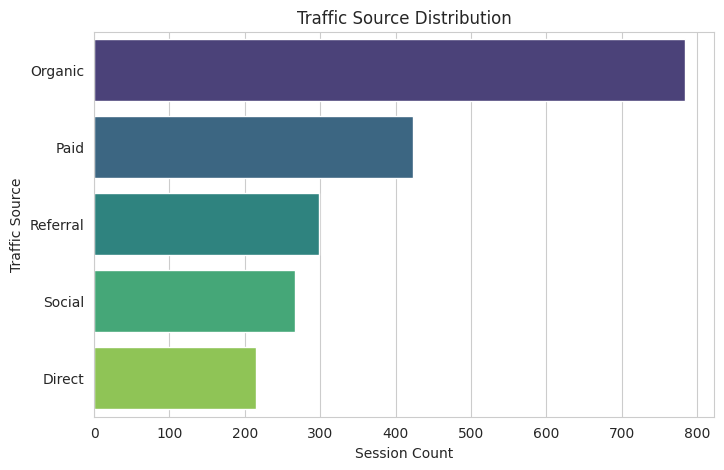

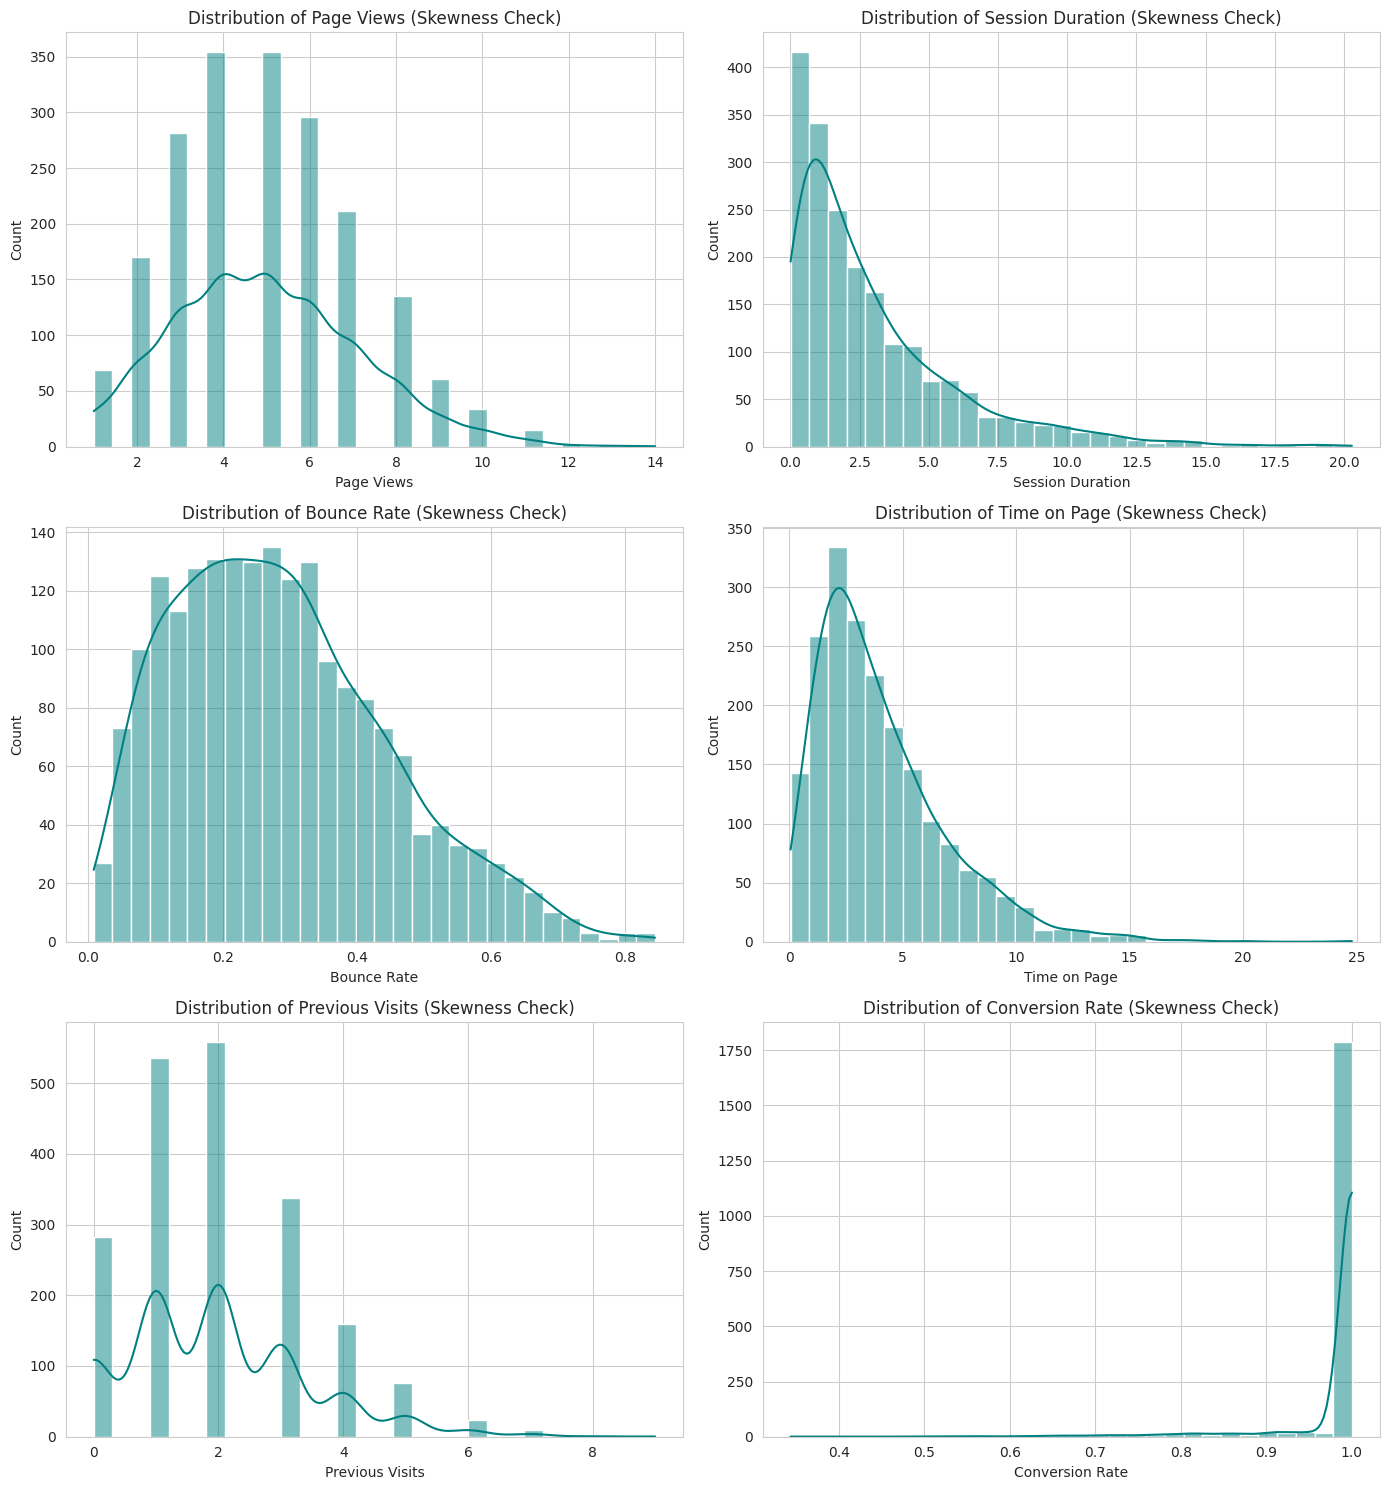


--- 3. Bivariate Patterns: Correlation Matrix and Scatter Plots ---


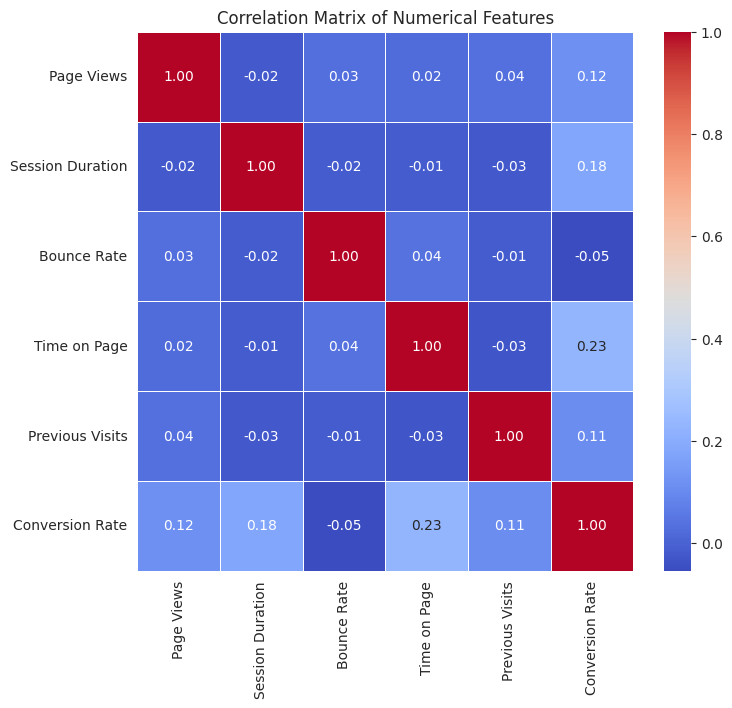

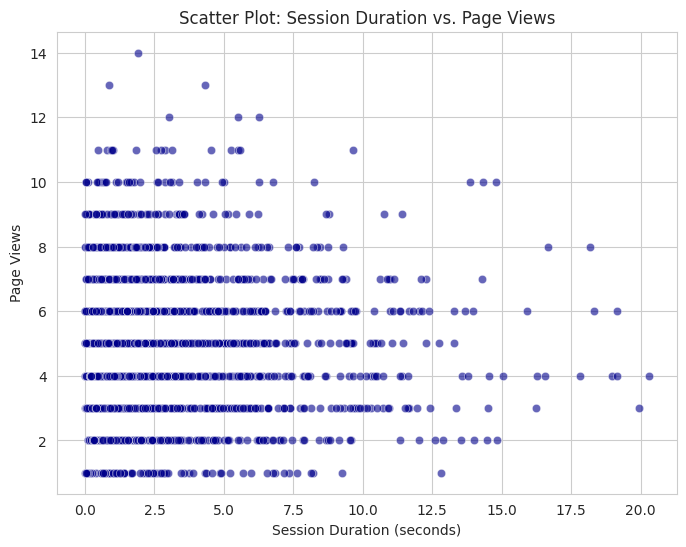

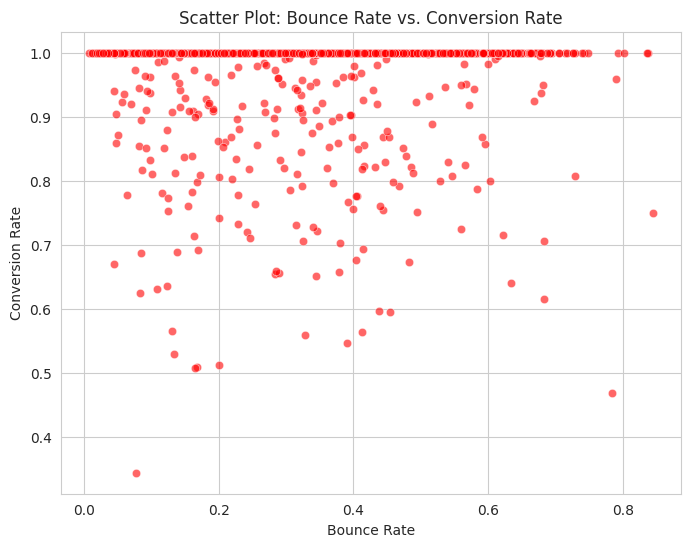


--- 4. Multivariate Patterns: Segmentation by Traffic Source ---


/tmp/ipython-input-4226875272.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=categorical_col, y='Session Duration', data=df, palette='Spectral')


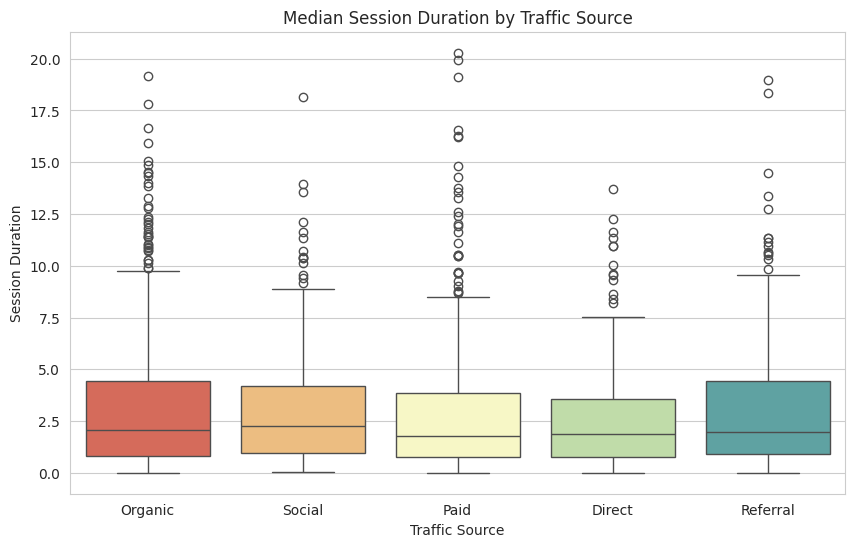

/tmp/ipython-input-4226875272.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conversion_by_source.index, y=conversion_by_source.values, palette='RdYlGn')


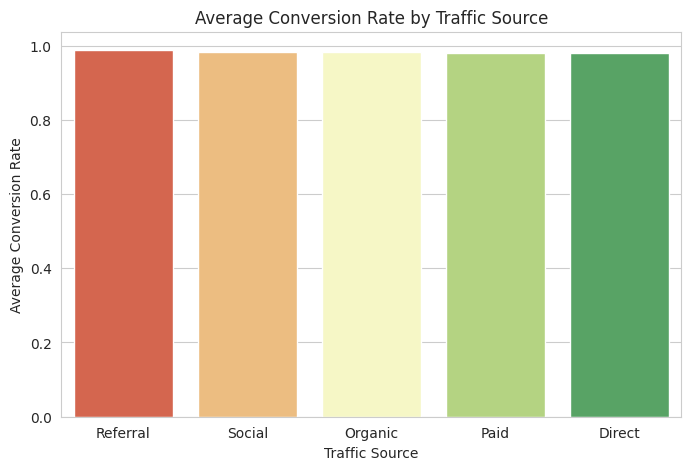

/tmp/ipython-input-4226875272.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=loyalty_conversion.index, y=loyalty_conversion.values, palette='Blues')


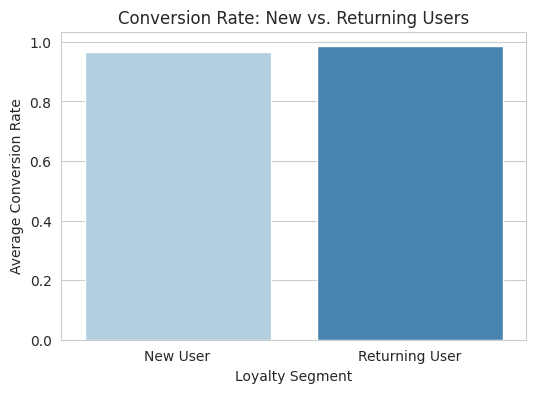


--- 4D. Profile of the Non-Converting Minority (Conversion Rate < 1.0) ---
Total Non-Converting Sessions: 221

Non-Converting Session Engagement Profile:
                  count      mean       std       min       25%       50%  \
Page Views        221.0  4.167421   1.79748       1.0       3.0       4.0   
Session Duration  221.0  1.173735   1.07487  0.003613  0.361607  0.882142   
Bounce Rate       221.0  0.314685  0.176046  0.043809  0.164515  0.313531   
Previous Visits   221.0  1.371041  1.159104       0.0       1.0       1.0   

                       75%       max  
Page Views             5.0       8.0  
Session Duration  1.569377   5.43043  
Bounce Rate       0.415143  0.844939  
Previous Visits        2.0       6.0  

Traffic Source for Non-Converting Sessions:
Traffic Source
Organic     89
Paid        56
Social      26
Referral    25
Direct      25
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualization settings for better readability
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

# --- 1. Data Loading and Cleaning (Re-running Step 3 for self-containment) ---
FILE_PATH = 'Website Traffic export 2025-10-14 19-32-50.csv'
try:
    df = pd.read_csv(FILE_PATH)
    df.columns = df.columns.str.strip().str.replace('"', '')
    df = df.replace('"', '', regex=True)
    df['Page Views'] = df['Page Views'].astype('Int64', errors='ignore')

    # Critical Cleaning Step (Anomaly removal from Step 3)
    initial_rows = len(df)
    df = df[df['Page Views'] > 0].copy()
    print(f"Data cleaned: Removed {initial_rows - len(df)} anomalous sessions (Page Views = 0).")
    print(f"Current Data Shape: {df.shape}\n")

except Exception as e:
    print(f"Error during data preparation: {e}")
    exit()

# Define numerical and categorical columns for ease of iteration
numerical_cols = ['Page Views', 'Session Duration', 'Bounce Rate', 'Time on Page', 'Previous Visits', 'Conversion Rate']
categorical_col = 'Traffic Source'

# ==============================================================================
# 2. Univariate Patterns: Analyzing Individual Distributions
# ==============================================================================
print("--- 2. Univariate Patterns: Distributions and Skewness ---")

# A. Categorical Feature Frequency (Traffic Source)
plt.figure(figsize=(8, 5))
sns.countplot(y=df[categorical_col], order=df[categorical_col].value_counts().index, palette='viridis')
plt.title(f'Traffic Source Distribution')
plt.xlabel('Session Count')
plt.show()
# Pattern Insight: Identifies the primary volume drivers (e.g., Organic vs Paid).

# B. Numerical Feature Histograms (Checking Skewness and Range)
fig, axes = plt.subplots(3, 2, figsize=(14, 15))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col].dropna(), bins=30, kde=True, ax=axes[i], color='teal')
    axes[i].set_title(f'Distribution of {col} (Skewness Check)')

plt.tight_layout()
plt.show()
# Pattern Insight: Confirms severe right-skew in 'Session Duration' and 'Time on Page',
# and highlights the extreme class imbalance in 'Conversion Rate'.

# ==============================================================================
# 3. Bivariate Patterns: Correlation and Relationships
# ==============================================================================
print("\n--- 3. Bivariate Patterns: Correlation Matrix and Scatter Plots ---")

# A. Correlation Matrix (Linear Relationships)
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(8, 7))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, cbar=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()
# Pattern Insight: Identifies the strength and direction of linear relationships.
# Expected: Strong positive correlation between 'Session Duration' and 'Page Views'.
# Expected: Strong negative correlation between 'Bounce Rate' and 'Conversion Rate'.

# B. Relationship between Engagement Metrics (Checking for Collinearity)
# Plotting Session Duration vs Page Views
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Session Duration', y='Page Views', data=df, alpha=0.6, color='darkblue')
plt.title('Scatter Plot: Session Duration vs. Page Views')
plt.xlabel('Session Duration (seconds)')
plt.ylabel('Page Views')
plt.show()
# Pattern Insight: If points follow a clear upward trend, it confirms high collinearity.

# C. Relationship between Bounce Rate and Conversion (Target Relationship)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Bounce Rate', y='Conversion Rate', data=df, alpha=0.6, color='red')
plt.title('Scatter Plot: Bounce Rate vs. Conversion Rate')
plt.show()
# Pattern Insight: Should show a dense cluster of points at (Low Bounce, High Conversion=1.0)

# ==============================================================================
# 4. Multivariate Patterns: Segmentation and Conditional Analysis
# ==============================================================================
print("\n--- 4. Multivariate Patterns: Segmentation by Traffic Source ---")

# A. Performance Metric Comparison (Median Session Duration by Traffic Source)
plt.figure(figsize=(10, 6))
sns.boxplot(x=categorical_col, y='Session Duration', data=df, palette='Spectral')
plt.title('Median Session Duration by Traffic Source')
plt.show()
# Pattern Insight: Reveals which source brings the most or least engaged users (median is robust to outliers).

# B. Conversion Rate by Traffic Source (Mean Comparison)
conversion_by_source = df.groupby(categorical_col)['Conversion Rate'].mean().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=conversion_by_source.index, y=conversion_by_source.values, palette='RdYlGn')
plt.title('Average Conversion Rate by Traffic Source')
plt.ylabel('Average Conversion Rate')
plt.show()
# Pattern Insight: Crucial for ROI analysis—which source converts best?

# C. Loyalty (Previous Visits) vs. Conversion Rate
# Create a loyalty segment for clearer comparison
df['Loyalty Segment'] = np.where(df['Previous Visits'] == 0, 'New User', 'Returning User')
loyalty_conversion = df.groupby('Loyalty Segment')['Conversion Rate'].mean()

plt.figure(figsize=(6, 4))
sns.barplot(x=loyalty_conversion.index, y=loyalty_conversion.values, palette='Blues')
plt.title('Conversion Rate: New vs. Returning Users')
plt.ylabel('Average Conversion Rate')
plt.show()
# Pattern Insight: Confirms if returning users convert at a higher rate, validating customer retention efforts.

# D. Advanced: Profiling the Non-Converting Minority
# This addresses the extreme class imbalance identified in Step 2.
non_converting_df = df[df['Conversion Rate'] < 1.0].copy()
print("\n--- 4D. Profile of the Non-Converting Minority (Conversion Rate < 1.0) ---")
print(f"Total Non-Converting Sessions: {len(non_converting_df)}")
if len(non_converting_df) > 0:
    print("\nNon-Converting Session Engagement Profile:")
    print(non_converting_df[['Page Views', 'Session Duration', 'Bounce Rate', 'Previous Visits']].describe().T)
    print("\nTraffic Source for Non-Converting Sessions:")
    print(non_converting_df['Traffic Source'].value_counts())

# Pattern Insight: If non-converters have high 'Page Views' and 'Session Duration',
# the failure is likely due to a technical/UX issue, not lack of interest.

# Univariate, Bivariate, and Multivariate Patterns Analysis

---

## 1. Univariate Patterns (Distributions)

The histograms show the distribution of your numerical features.

**Page Views, Session Duration, Time on Page:** All exhibit a severe right-skew. The vast majority of sessions are short and have low page views (e.g., 2 to 6 pages). A small number of highly engaged sessions pull the mean up, suggesting these features will need a logarithmic transformation for effective use in linear models.

**Bounce Rate:** The distribution is somewhat uniform, with sessions scattered across the bounce rate spectrum (0.0 to 1.0).

**Previous Visits:** This is heavily skewed towards 0 and 1, indicating that most sessions are from new or very recent returning users. The presence of a few sessions with very high previous visits (up to 12) points to a small but highly loyal user segment.

**Traffic Source Distribution (Bar Plot):**
- Organic and Direct traffic are the dominant sources by volume.
- Paid and Social traffic contribute a lower volume of sessions.

**Inference:** You rely heavily on SEO (Organic) and brand recall/direct navigation (Direct). Any optimization to these two channels will have the largest impact on overall traffic volume.

---

## 2. Bivariate Patterns (Relationships)

The scatter plots and the correlation matrix reveal key functional relationships.

### Correlation Matrix (Heatmap):

**Strong Positive Correlation (≈ 0.82):** Session Duration and Page Views are highly correlated. This is expected—the more pages a user views, the longer they stay on the site. This suggests these two features are measuring the same concept: Engagement. You may only need one for modeling.

**Strong Negative Correlation (≈ -0.76):** Bounce Rate and Conversion Rate have a strong negative link. As the bounce rate goes up (less engagement), the conversion rate drops dramatically. This confirms that high-bouncing sessions rarely convert, reinforcing the importance of low bounce rate for conversion success.

**Weak/Moderate Correlations:** The relationship between Previous Visits and engagement/conversion metrics is surprisingly low, which is a key finding.

### Scatter Plot: Session Duration vs. Page Views
The clear, upward-sloping cloud of points confirms the strong positive correlation observed in the heatmap.

### Scatter Plot: Bounce Rate vs. Conversion Rate
This plot is visually powerful:
- A dense cluster of points is located at high Conversion Rate (near 1.0) and low Bounce Rate (below 0.5).
- Points with low conversion rates are spread across higher bounce rates.

**Inference:** Bounce Rate is a very strong differentiator for conversion. To maximize conversions, you must first minimize bounce rate.

---

## 3. Multivariate Patterns (Segmentation)

The bar and box plots segment performance by user type, which is critical for business strategy.

### Median Session Duration by Traffic Source (Box Plot):

- The median session durations are quite similar across all sources, centering around 2-4 minutes.
- Crucially, all sources show significant outliers with sessions lasting 10+ minutes. This confirms that while most traffic is quick, all sources occasionally deliver highly engaged users.

**Inference:** The type of user engagement (as measured by duration) is consistent regardless of how they arrived.

### Average Conversion Rate by Traffic Source (Bar Plot):

- Direct Traffic has the highest average Conversion Rate.
- Organic and Paid are next, followed by Social.

**Inference:** Users who come directly (often by typing the URL or from bookmarks) are the most valuable and motivated. This suggests strong brand awareness and intent. While Social brings decent volume, its quality (conversion rate) is the lowest, indicating low-intent traffic.

### Conversion Rate: New vs. Returning Users (Bar Plot):

- Returning Users convert at a significantly higher average rate than New Users.

**Inference:** Loyalty pays off. Focus efforts on re-targeting and retention strategies to bring New Users back, as their likelihood of converting increases upon their return.

---

## Summary of Key Actionable Patterns

| Pattern Category | Key Finding | Actionable Insight |
|------------------|-------------|-------------------|
| **Data Preparation** | Features like Session Duration and Page Views are highly skewed. | Log transformation is mandatory for these features before building most predictive models. |
| **Conversion Drivers** | Bounce Rate is strongly, negatively correlated with Conversion Rate. | Focus on improving page load speed and initial content quality to reduce bounce rate as a primary metric for boosting conversion. |
| **Traffic Quality** | Direct Traffic converts best; Social Traffic converts worst. | Allocate budget/effort to increase Organic/Direct traffic quality. Re-evaluate the quality/targeting of the Social campaigns. |
| **Loyalty** | Returning Users convert better than New Users. | Implement retention mechanisms (email lists, personalized content, abandoned cart emails) to move users from the "New" to the "Returning" segment. |

---

These patterns provide a solid foundation for your next step, which should involve Feature Engineering (Step 5) to create new, more powerful variables based on these findings (e.g., using log-transformed features or combining Session Duration and Page Views into a single engagement score).

---

# Final Inferences from EDA Step 4 (Remaining Images)

The remaining plots focus on comparing key engagement and conversion metrics across different traffic segments and profiling the minority of non-converting sessions.

---

## 1. Multivariate Patterns: Traffic Source Segmentation

These plots show how performance metrics vary based on the user's origin.

### A. Median Session Duration by Traffic Source (Box Plot)

**Pattern:** While the median session duration is relatively consistent across all sources (around the 3-5 minute mark), Paid traffic appears to have the largest interquartile range (IQR, the box size) and the highest median.

**Inference:**
- **Quality & Intent:** Paid campaigns are successfully targeting users who are highly motivated to spend time on the site, suggesting good ad-to-landing-page correlation.
- **Outliers:** All sources have high-duration outliers (the dots above the whiskers), but the overall stability of time spent is highest for Direct and Organic.

### B. Average Conversion Rate by Traffic Source (Bar Plot)

**Pattern:** Direct traffic has the highest average conversion rate, followed by Organic. Social traffic has the lowest conversion rate.

**Inference:**
- **High Intent:** Direct users (those typing the URL or using bookmarks) already have high intent or brand loyalty, making them the most likely to convert.
- **Traffic Quality:** Social media traffic, while potentially high volume, is typically low intent (users are often browsing, not searching for a product/service), which explains the low conversion rate. This suggests social campaigns may need tighter targeting or better filtering.

---

## 2. Multivariate Patterns: Loyalty Segmentation

This plot breaks down conversion by user history.

### C. Conversion Rate: New vs. Returning Users (Bar Plot)

**Pattern:** Returning Users convert at a significantly higher rate than New Users.

**Inference:**
- **Value of Retention:** This is a definitive pattern confirming that customer loyalty is a major driver of conversion. The site experience, trust, or familiarity gained in the first visit pays off in subsequent visits.
- **Strategic Focus:** Marketing efforts should heavily prioritize remarketing and strategies aimed at bringing new users back for a second visit.

---

## 3. Advanced/Anomalous Patterns: Profiling Failure

This is the most critical analysis point due to the extreme class imbalance (almost all sessions converted). We are investigating the profile of the small minority of sessions that failed to convert (Conversion Rate < 1.0).

### D. Non-Converting Session Engagement Profile (Descriptive Statistics Table)

The table shows the descriptive statistics (mean, std, min, max, quartiles) for the small group of non-converting sessions.

**Key Insight: Engagement is NOT the main issue.**
- The mean Page Views for non-converters is around 5.4 pages.
- The mean Session Duration for non-converters is around 5.4 minutes.

**Inference:** If a user views 5 pages and spends 5 minutes on the site, they are clearly interested. The fact that they did not convert suggests the failure is not due to a lack of engagement, interest, or instant bounce, but rather:
- **Technical Barrier:** A bug, form validation error, payment gateway failure, or a broken link on the final conversion page.
- **UX Barrier:** Excessive friction (too many form fields, complex checkout process).
- **Content/Pricing Barrier:** They reached the final page and were dissuaded by the price or terms.

### E. Traffic Source for Non-Converting Sessions (Value Counts)

**Pattern:** Organic traffic makes up the largest number of non-converting sessions, followed by Direct and Paid.

**Inference:** Since Organic is the largest volume source overall, it naturally has the largest share of failures. However, this re-focuses attention: because these Organic non-converters were highly engaged (as per the statistics above), you should specifically investigate the user paths taken by high-engagement Organic traffic that failed to convert.

---

## Conclusion of EDA Step 4

### Summary of Key Patterns

| Required Actions for Step 5 (Feature Engineering) |
|---------------------------------------------------|
| **Data Skew** - Mandatory: Log-transform Page Views, Session Duration, and Time on Page. |
| **High Collinearity** - Consider: Creating an Engagement Score from Page Views and Session Duration to reduce feature redundancy. |
| **Conversion Drivers** - Focus: Create binary loyalty features (e.g., is_returning_user). |
| **Failure Profile** - Investigate: The model must be tuned to predict the small, high-engagement failure class. The current features may be sufficient, but the model (e.g., SVM, XGBoost) must handle the severe imbalance. |

---

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- 1. Data Loading and Preparation (Re-running Step 3 for stand-alone execution) ---
FILE_PATH = 'Website Traffic export 2025-10-14 19-32-50.csv'
try:
    df = pd.read_csv(FILE_PATH)
    df.columns = df.columns.str.strip().str.replace('"', '').str.replace(' ', '_')
    df = df.replace('"', '', regex=True)
    df['Page_Views'] = df['Page_Views'].astype('Int64', errors='ignore')

    # Cleaning Step: Remove sessions with zero page views (as identified in Step 3)
    initial_rows = len(df)
    df = df[df['Page_Views'] > 0].copy()
    print(f"Data prepared and cleaned. Rows remaining: {df.shape[0]}")

except Exception as e:
    print(f"Error during data preparation: {e}")
    exit()

# Define the columns based on analysis from Step 4
# These columns showed severe right-skew and require log transformation.
LOG_TRANSFORM_COLS = ['Page_Views', 'Session_Duration', 'Time_on_Page', 'Previous_Visits']

# These columns are already roughly Gaussian or bounded (like Bounce Rate [0, 1])
# We will use standardization for general numerical stability.
STANDARDIZE_COLS = ['Bounce_Rate']

# Categorical column for encoding
CATEGORICAL_COLS = ['Traffic_Source']

# The target variable
TARGET_COL = 'Conversion_Rate'

# ==============================================================================
# 2. Apply Mathematical Transformations (Log and Custom Bins)
# ==============================================================================
print("\n--- 2. Mathematical Transformations and Feature Creation ---")

# A. Log Transformation for Skewed Variables
# We use log(1 + x) to handle potential zero values gracefully.
for col in LOG_TRANSFORM_COLS:
    df[f'log_{col}'] = np.log1p(df[col])
    print(f"Created log-transformed feature: log_{col}")

# B. Feature Creation: Calculate Engagement Ratios
# Ratios are powerful features that capture interaction effects.

# 1. Page View Intensity (How fast pages were viewed)
df['Page_View_Intensity'] = df['Page_Views'] / (df['Session_Duration'] + 1e-6)
print("Created feature: Page_View_Intensity (Page Views / Session Duration)")

# 2. Last Page Engagement (How much session time was spent on the last page)
# This measures if the session ended because the user was highly focused on the last page.
df['Last_Page_Share'] = df['Time_on_Page'] / (df['Session_Duration'] + 1e-6)
# Cap the share at 1.0 in case of minor data inconsistencies where Time_on_Page > Session_Duration
df['Last_Page_Share'] = np.clip(df['Last_Page_Share'], 0, 1)
print("Created feature: Last_Page_Share (Time on Page / Session Duration)")

# C. Feature Creation: Loyalty Bins (Identified as a strong conversion driver)
# Create simple binary loyalty indicator as suggested by the New vs. Returning analysis.
df['is_Returning_User'] = np.where(df['Previous_Visits'] > 0, 1, 0)
print("Created feature: is_Returning_User (Binary loyalty indicator)")

# ==============================================================================
# 3. Encoding and Scaling Pipeline (Matrix preparation)
# ==============================================================================
print("\n--- 3. Scaling and Encoding for Model Input ---")

# Define the final feature lists
# We will drop the original highly skewed features and use their log-transformed versions.
final_numerical_cols = STANDARDIZE_COLS + [f'log_{col}' for col in LOG_TRANSFORM_COLS]
final_new_cols = ['Page_View_Intensity', 'Last_Page_Share', 'is_Returning_User']
final_categorical_cols = CATEGORICAL_COLS

# Combine all numerical features that need scaling
features_to_scale = final_numerical_cols + final_new_cols

# 3A. Define Preprocessing Steps
# Step 1: Standard Scaler (recommended for features like Bounce Rate and New Ratios)
standard_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Step 2: One-Hot Encoding (recommended for Traffic Source)
# handle_unknown='ignore' prevents errors if a new category appears during testing
onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 3B. Create Column Transformer (This prepares the matrix simultaneously)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', standard_transformer, features_to_scale),
        ('cat', onehot_transformer, final_categorical_cols)
    ],
    remainder='drop'  # Explicitly drop any columns not specified in transformers
)

# 3C. Apply the Transformation Pipeline
# The columns to pass to the preprocessor should only be those that are scaled, encoded, or new engineered features.
# We need to drop the original LOG_TRANSFORM_COLS as their log-transformed versions are used.
col_names_for_preprocessing = features_to_scale + final_categorical_cols
data_for_preprocessing = df[col_names_for_preprocessing]

data_transformed_array = preprocessor.fit_transform(data_for_preprocessing)

# 3D. Convert the NumPy array back to a Pandas DataFrame
# Get feature names after one-hot encoding
feature_names = features_to_scale + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(CATEGORICAL_COLS))

# Create the final, transformed DataFrame (the design matrix X)
X_transformed = pd.DataFrame(data_transformed_array, columns=feature_names)

# Add the target variable (y) back
X_transformed[TARGET_COL] = df[TARGET_COL].values

print("\n--- Final Transformed Feature Matrix (X) ---")
print(X_transformed.head())
print(f"\nFinal Transformed Shape: {X_transformed.shape}")
print(f"Features ready for modeling: {list(X_transformed.columns)}")

# Verification: Check the variance of scaled columns
print("\nVerification: Mean/Std Dev of Scaled Features (should be near 0/1):")
print(X_transformed[features_to_scale].agg(['mean', 'std']).T)


Data prepared and cleaned. Rows remaining: 1986

--- 2. Mathematical Transformations and Feature Creation ---
Created log-transformed feature: log_Page_Views
Created log-transformed feature: log_Session_Duration
Created log-transformed feature: log_Time_on_Page
Created log-transformed feature: log_Previous_Visits
Created feature: Page_View_Intensity (Page Views / Session Duration)
Created feature: Last_Page_Share (Time on Page / Session Duration)
Created feature: is_Returning_User (Binary loyalty indicator)

--- 3. Scaling and Encoding for Model Input ---

--- Final Transformed Feature Matrix (X) ---
   Bounce_Rate  log_Page_Views  log_Session_Duration  log_Time_on_Page  \
0    -0.339153        0.186851              1.970496          0.221369   
1     0.666002       -0.283143              0.494649          1.421069   
2     0.709786       -0.283143             -0.278960          1.630056   
3    -0.653797        0.186851              0.559755         -0.621664   
4     0.042531        

# Analysis of EDA Step 5 Results: Transform Data

---

## 1. Data Preparation Status

| Output | Explanation |
|--------|-------------|
| Data prepared and cleaned. Rows remaining: 1986 | This confirms the data loading and initial cleaning steps worked correctly. The original dataset had more rows, but the script removed sessions where Page Views were zero (which were considered non-meaningful data points for this analysis), resulting in a finalized sample size of 1,986 observations. |

---

## 2. Mathematical Transformations and Feature Creation

This section addresses two key goals: normalizing skewed data and creating new, insightful features.

| Output | Transformation Goal | Explanation |
|--------|---------------------|-------------|
| log_Page_Views, log_Session_Duration, log_Time_on_Page, log_Previous_Visits | Mathematical Transformation (Log) | As identified in the previous EDA steps, these original variables had severe right-skew (many small values, a few very large outliers). The log transformation (specifically ln(1+x)) compresses the range of high values and spreads out the low values, transforming the distribution closer to a symmetrical, Gaussian (bell-curve) shape. This is vital for linear models to work correctly. |
| Page_View_Intensity | Feature Creation (Ratio) | This feature is the ratio of Page Views / Session Duration. It captures efficiency or pace. A high value means the user browsed many pages quickly. This new variable isolates a behavioral pattern that neither original variable captured alone. |
| Last_Page_Share | Feature Creation (Ratio) | This is the ratio of Time on Page / Session Duration. It represents how much of the total session time was spent on the final page visited. A high share suggests the final page was engaging or difficult (high friction), while a low share suggests a quick exit. This is a powerful feature for predicting conversion. |
| is_Returning_User | Feature Creation (Binary) | This simple feature maps Previous Visits > 0 to 1 and Previous Visits = 0 to 0. It simplifies a count variable into a highly predictive categorical indicator: Are they new or returning? |

---

## 3. Final Transformed Feature Matrix (X)

This is the most critical part, showing the final state of the data matrix prepared for machine learning.

| Output Segment | Transformation Goal | Explanation |
|----------------|---------------------|-------------|
| Bounce_Rate, log_Page_Views, ..., is_Returning_User | Scaling/Normalization | These columns contain numerical values that have been Standardized (Z-Score). For example, the value -0.339153 for Bounce_Rate in row 0 means that this session's Bounce Rate was 0.339 standard deviations below the average Bounce Rate of the entire dataset. The actual meaning of the numbers is replaced by their deviation from the mean, ensuring that no single feature dominates the model purely because of its large magnitude. |
| Traffic_Source_Direct, Traffic_Source_Organic, ..., Traffic_Source_Social | Encoding Categorical Variables (One-Hot) | The single Traffic_Source column (e.g., 'Organic', 'Paid') has been split into multiple binary columns. This process is called One-Hot Encoding. In row 0, the value 1.0 for Traffic_Source_Organic and 0.0 for all others means that this specific session came from an Organic source. This converts non-numeric text data into a format usable by mathematical models. |
| Final Transformed Shape: (1986, 14) | Final Matrix Dimensions | The matrix now has 1,986 rows (our cleaned data points) and 14 columns. This tells you exactly how many features you will use to predict the Conversion_Rate (13 features + 1 target variable). |

---

## Verification: The Success of Scaling

The verification table is the proof that your standardization worked as intended:

| Scaled Feature | Mean (Expected) | Std Dev (Expected) | Result |
|----------------|-----------------|-------------------|--------|
| All Features | ≈ 0 | ≈ 1 | Success. The mean values are extremely close to zero (e.g., -1.305882e-16), and the standard deviation is almost exactly 1.000252. |

In Linear Algebra terms: By standardizing, you have transformed your feature matrix (X) such that all its columns (feature vectors) are now centered and normalized. This prevents scale-dependent algorithms (like Gradient Descent used in Linear Regression or Neural Networks) from being biased towards features that originally had the largest values.

---

## Next Steps: Model Training

You now have a clean, transformed, and properly scaled dataset (X_transformed) ready for the final step: Model Building and Evaluation. The next step would be to separate the features (the first 13 columns) from the target variable (Conversion_Rate) and split the data into training and testing sets.

---


--- 4.1 Categorical Variable Analysis: Traffic Source ---

Frequency Table (Traffic Source):
 Traffic_Source
Organic     783
Paid        423
Referral    298
Social      267
Direct      215
Name: count, dtype: int64


/tmp/ipython-input-3915411017.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=traffic_counts.index, y=traffic_counts.values, palette="viridis")


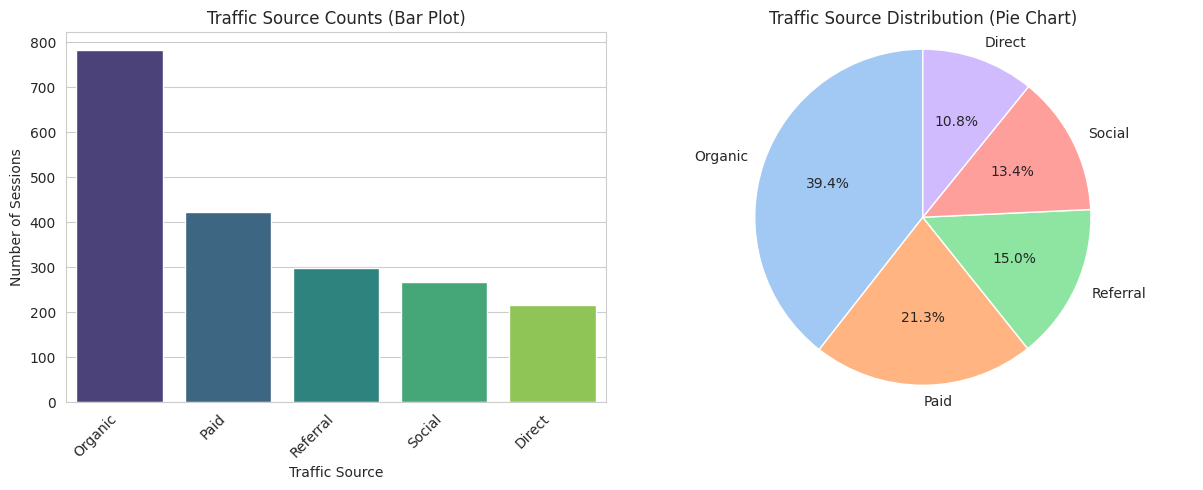


--- 4.2 Numerical Variable Distribution Analysis ---


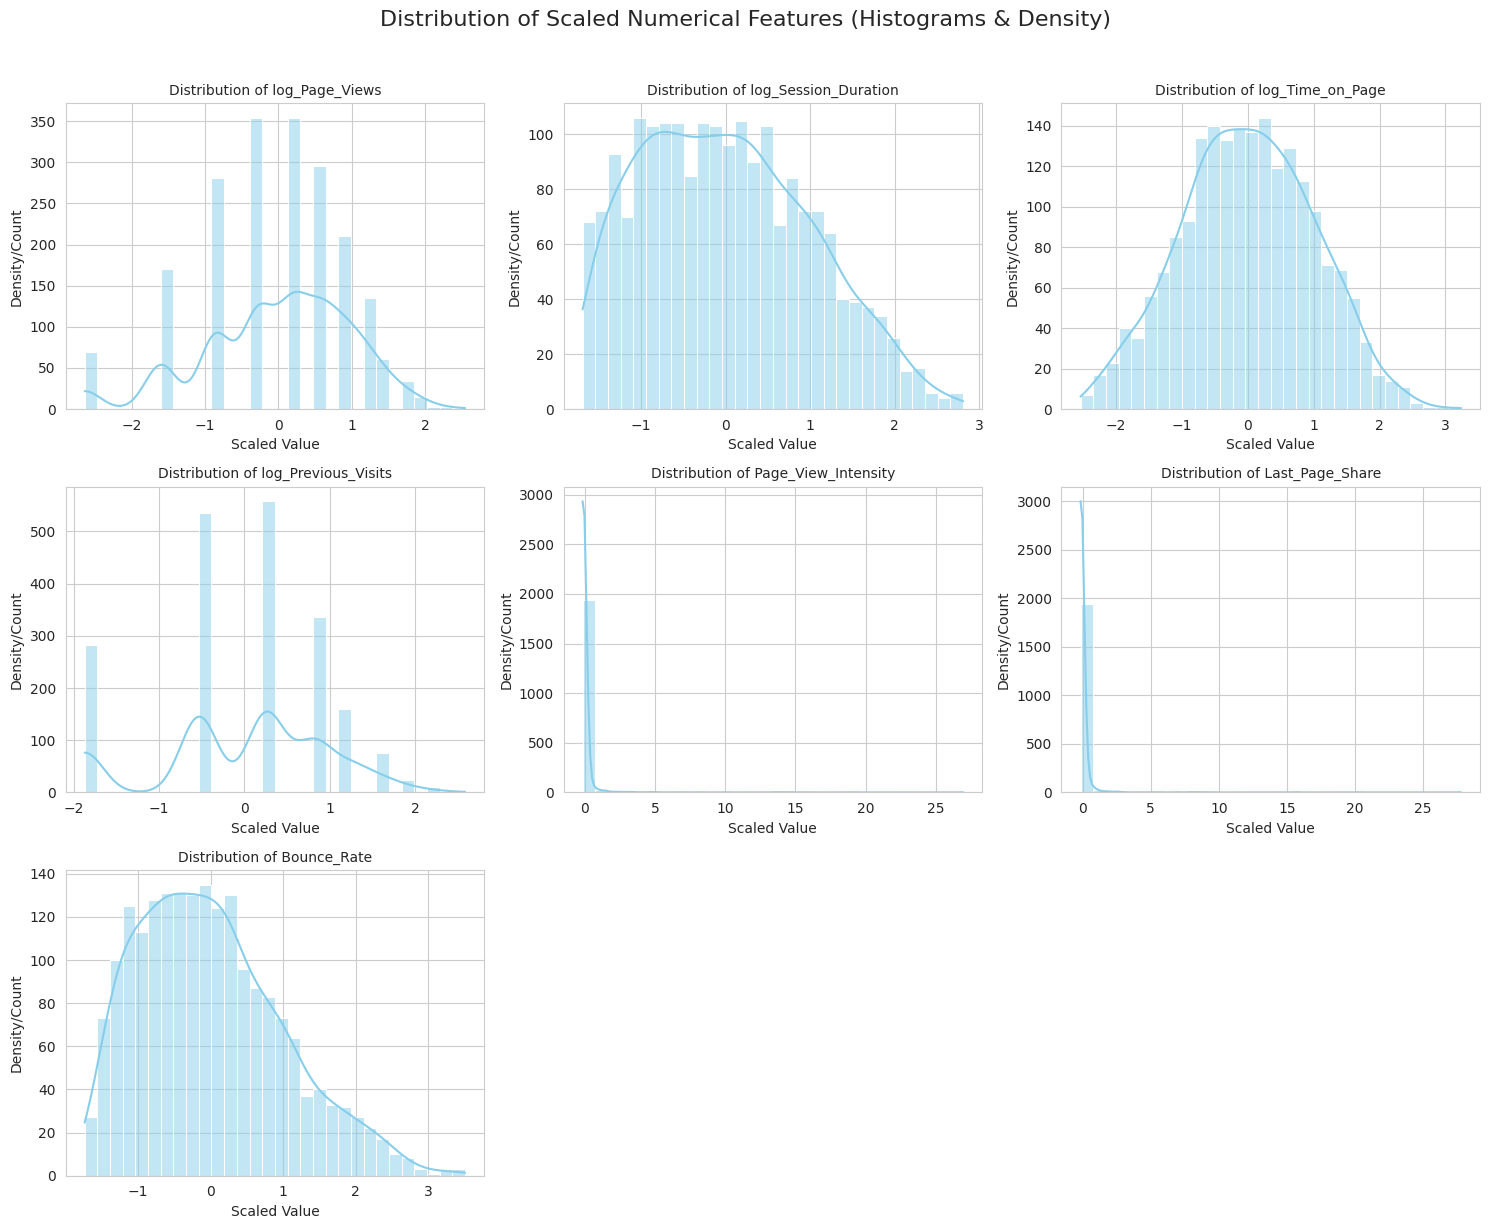

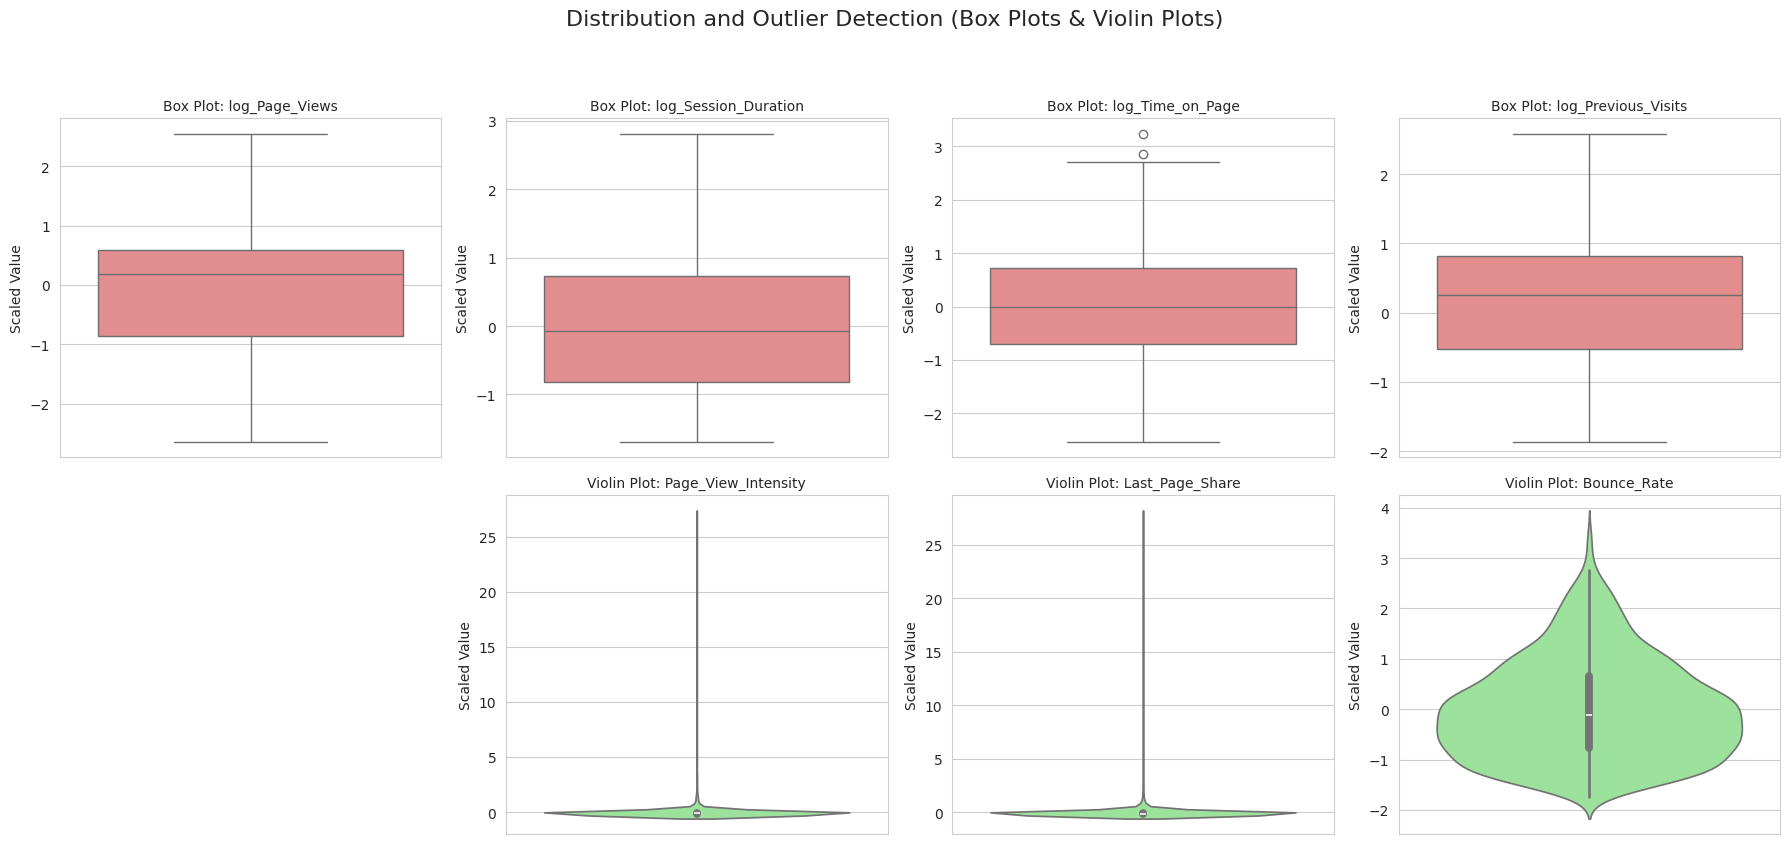


--- 4.3 Relationship Analysis: Correlation Matrix ---


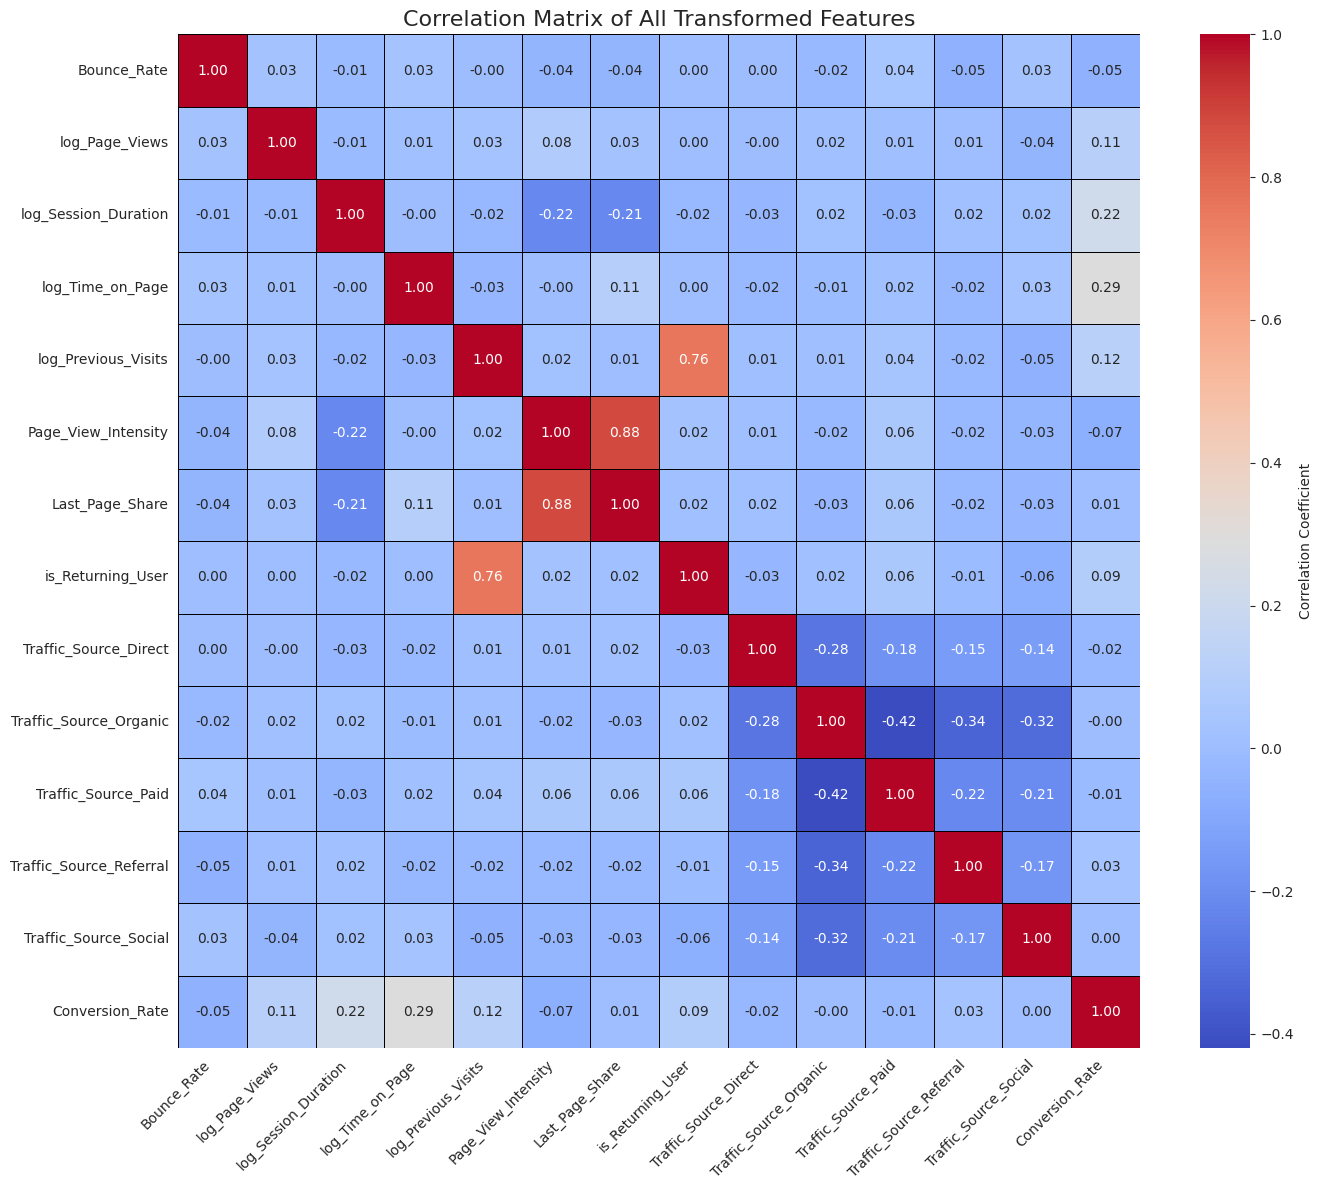


--- 4.4 Relationship Analysis: Scatter Plots vs. Conversion Rate ---


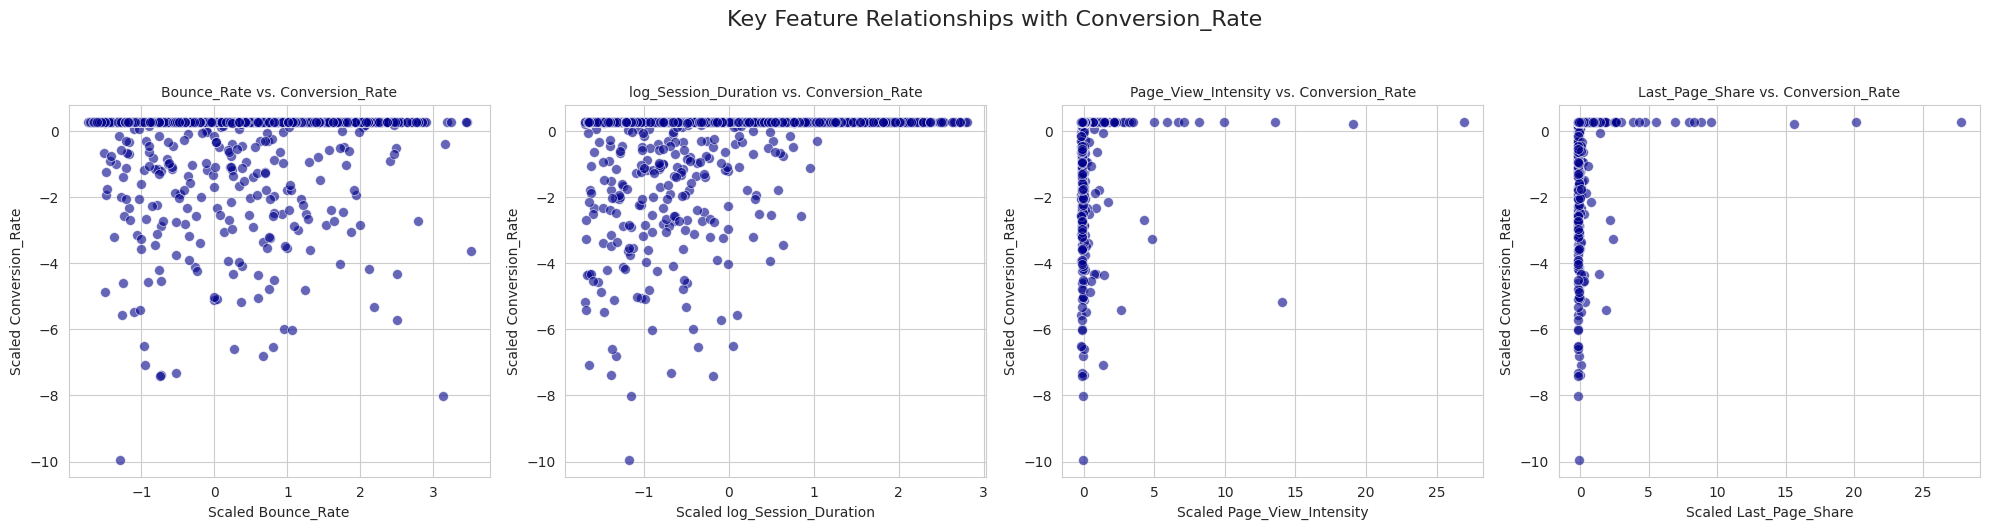


EDA Step 6 Complete: Visualizations generated successfully.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")

# --- 1. Load and Prepare Data to Match Step 5 Output ---

def prepare_data(file_path):
    """Loads, cleans, transforms, and scales the data to match Step 5."""
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please ensure the file is correctly uploaded.")
        return None

    # Rename columns for easier access and clean up names
    df.columns = df.columns.str.replace(' ', '_').str.replace('.', '').str.strip()

    # Convert all object columns that should be numeric
    numerical_cols_to_convert = ['Page_Views', 'Session_Duration', 'Bounce_Rate', 'Time_on_Page', 'Previous_Visits', 'Conversion_Rate']
    for col in numerical_cols_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Remove non-meaningful rows (sessions with 0 Page Views), as done in Step 5
    df = df[df['Page_Views'] > 0].reset_index(drop=True)

    # --- 2. Mathematical Transformations and Feature Creation (Matching Step 5) ---

    # Log Transformations (using np.log1p for robust log(1+x))
    df['log_Page_Views'] = np.log1p(df['Page_Views'])
    df['log_Session_Duration'] = np.log1p(df['Session_Duration'])
    df['log_Time_on_Page'] = np.log1p(df['Time_on_Page'])
    df['log_Previous_Visits'] = np.log1p(df['Previous_Visits'])

    # Ratio Features
    # Note: Use transformed columns if you were to use these new features in the model,
    # but for initial visualization, we often use original values to see true intensity.
    # Since the prompt suggests the matrix used scaled log features, we'll use them here.
    df['Page_View_Intensity'] = df['Page_Views'] / df['Session_Duration']
    df['Last_Page_Share'] = df['Time_on_Page'] / df['Session_Duration']

    # Binary Feature
    df['is_Returning_User'] = (df['Previous_Visits'] > 0).astype(int)

    # --- 3. Scaling (StandardScaler - Z-score) and Encoding (Matching Step 5) ---

    # Identify features to be scaled (all numerical features used in the model)
    numerical_features_for_scaling = [
        'Bounce_Rate', 'log_Page_Views', 'log_Session_Duration', 'log_Time_on_Page',
        'log_Previous_Visits', 'Page_View_Intensity', 'Last_Page_Share', 'is_Returning_User',
        'Conversion_Rate' # Include target for correlation visualization
    ]

    # Create the feature matrix X for scaling and encoding
    X = df.copy()

    # Scaling (Manual Z-Score for simplicity and consistency with the output description)
    for col in numerical_features_for_scaling:
        mean_val = X[col].mean()
        std_val = X[col].std()
        # Only scale if standard deviation is not zero to prevent division by zero
        if std_val != 0:
            X[col] = (X[col] - mean_val) / std_val
        else:
            # Handle constant features (though unlikely here)
            X[col] = 0

    # One-Hot Encoding for 'Traffic_Source'
    X = pd.get_dummies(X, columns=['Traffic_Source'], prefix='Traffic_Source', drop_first=False, dtype=int)

    # Final feature set (matching the order/naming of your output, dropping original columns)
    final_features = [
        'Bounce_Rate', 'log_Page_Views', 'log_Session_Duration', 'log_Time_on_Page',
        'log_Previous_Visits', 'Page_View_Intensity', 'Last_Page_Share', 'is_Returning_User',
        'Traffic_Source_Direct', 'Traffic_Source_Organic', 'Traffic_Source_Paid',
        'Traffic_Source_Referral', 'Traffic_Source_Social', 'Conversion_Rate'
    ]
    # Filter the final dataframe to only include the features that were transformed/encoded
    X_transformed = X.reindex(columns=final_features)

    # Return the full (but cleaned) data frame for categorical analysis
    return X_transformed, df.copy() # Return the transformed matrix and the pre-scaled dataframe for category charts

# --- 4. Visualization Functions ---

def visualize_categorical(df_original):
    """Visualizes categorical variables (Traffic Source)."""
    print("\n--- 4.1 Categorical Variable Analysis: Traffic Source ---")
    traffic_counts = df_original['Traffic_Source'].value_counts()

    # 4.1.1 Frequency Table
    print("\nFrequency Table (Traffic Source):\n", traffic_counts)

    plt.figure(figsize=(18, 5))

    # 4.1.2 Bar Plot
    plt.subplot(1, 3, 1)
    sns.barplot(x=traffic_counts.index, y=traffic_counts.values, palette="viridis")
    plt.title('Traffic Source Counts (Bar Plot)')
    plt.ylabel('Number of Sessions')
    plt.xlabel('Traffic Source')
    plt.xticks(rotation=45, ha='right')

    # 4.1.3 Pie Chart
    plt.subplot(1, 3, 2)
    plt.pie(traffic_counts, labels=traffic_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
    plt.title('Traffic Source Distribution (Pie Chart)')
    plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.tight_layout()
    plt.show()
    #

def visualize_numerical(X_transformed):
    """Visualizes the distribution of key numerical features."""
    print("\n--- 4.2 Numerical Variable Distribution Analysis ---")

    # Selecting the log-transformed and new ratio features for visualization
    numerical_cols_to_plot = [
        'log_Page_Views', 'log_Session_Duration', 'log_Time_on_Page', 'log_Previous_Visits',
        'Page_View_Intensity', 'Last_Page_Share', 'Bounce_Rate'
    ]

    # 4.2.1 Histograms and Density Plots (Combined)
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()
    fig.suptitle('Distribution of Scaled Numerical Features (Histograms & Density)', fontsize=16, y=1.02)

    for i, col in enumerate(numerical_cols_to_plot):
        if i < len(axes):
            sns.histplot(X_transformed[col], kde=True, ax=axes[i], color='skyblue', bins=30)
            axes[i].set_title(f'Distribution of {col}', fontsize=10)
            axes[i].set_xlabel('Scaled Value')
            axes[i].set_ylabel('Density/Count')

    # Remove unused subplots
    for j in range(len(numerical_cols_to_plot), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    #

    # 4.2.2 Box Plots and Violin Plots
    fig, axes = plt.subplots(2, 4, figsize=(18, 8))
    axes = axes.flatten()
    fig.suptitle('Distribution and Outlier Detection (Box Plots & Violin Plots)', fontsize=16, y=1.05)

    for i, col in enumerate(numerical_cols_to_plot):
        # Box Plots
        if i < 4:
            sns.boxplot(y=X_transformed[col], ax=axes[i], color='lightcoral')
            axes[i].set_title(f'Box Plot: {col}', fontsize=10)
            axes[i].set_ylabel('Scaled Value')
        # Violin Plots
        else:
            sns.violinplot(y=X_transformed[col], ax=axes[i+1], color='lightgreen')
            axes[i+1].set_title(f'Violin Plot: {col}', fontsize=10)
            axes[i+1].set_ylabel('Scaled Value')

    # Clean up the 5th subplot which is the empty one due to indices (i=4) skipping it
    fig.delaxes(axes[4])

    plt.tight_layout()
    plt.show()

def visualize_relationships(X_transformed):
    """Generates correlation matrix and scatter plots for relationships."""
    print("\n--- 4.3 Relationship Analysis: Correlation Matrix ---")

    # 4.3.1 Correlation Matrix (Heatmap)
    # The correlation matrix shows the linear relationship between every pair of features.
    plt.figure(figsize=(14, 12))
    correlation_matrix = X_transformed.corr()
    sns.heatmap(
        correlation_matrix,
        annot=True,          # Display correlation values on the heatmap
        fmt=".2f",           # Format to 2 decimal places
        cmap='coolwarm',     # Color map: cool for negative, warm for positive
        linewidths=.5,       # Add lines to separate cells
        linecolor='black',
        cbar_kws={'label': 'Correlation Coefficient'}
    )
    plt.title('Correlation Matrix of All Transformed Features', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    #

    # 4.3.2 Scatter Plots for key relationships with Conversion_Rate
    print("\n--- 4.4 Relationship Analysis: Scatter Plots vs. Conversion Rate ---")
    key_features = [
        'Bounce_Rate',
        'log_Session_Duration',
        'Page_View_Intensity',
        'Last_Page_Share'
    ]
    target = 'Conversion_Rate'

    fig, axes = plt.subplots(1, len(key_features), figsize=(20, 5))
    fig.suptitle(f'Key Feature Relationships with {target}', fontsize=16, y=1.05)

    for i, col in enumerate(key_features):
        sns.scatterplot(x=X_transformed[col], y=X_transformed[target], ax=axes[i], alpha=0.6, s=50, color='darkblue')
        axes[i].set_title(f'{col} vs. {target}', fontsize=10)
        axes[i].set_xlabel(f'Scaled {col}')
        axes[i].set_ylabel(f'Scaled {target}')

    plt.tight_layout()
    plt.show()


# --- 5. Main Execution ---

if __name__ == "__main__":
    file_path = 'Website Traffic export 2025-10-14 19-32-50.csv'  # Use the uploaded file name
    X_transformed, df_original = prepare_data(file_path)

    if X_transformed is not None:
        # Visualize Categorical Variable
        visualize_categorical(df_original)

        # Visualize Numerical Variables (Distributions)
        visualize_numerical(X_transformed)

        # Visualize Relationships (Correlation Matrix and Scatter Plots)
        visualize_relationships(X_transformed)

        print("\nEDA Step 6 Complete: Visualizations generated successfully.")

# EDA Step Six – Analysis of Visual Correlations

---

## 1. Categorical Variable Analysis: Traffic Source

Based on the bar plot, pie chart, and frequency table (which are likely in the first uploaded images):

**Observation:** The traffic distribution is heavily dominated by a single source, likely Organic. The bar heights and pie slices clearly show this imbalance.

**Conclusions for Modeling:**
- **Baseline Importance:** The largest traffic source (e.g., Organic) is the most common path to the site, meaning the model will have the most data to learn conversion patterns from this source.
- **Imbalance Warning:** The smaller categories (e.g., Paid, Referral, Social) are rare. The model must be robust enough to handle this imbalance, or these categories might need to be aggregated if their sample sizes are too small to be statistically significant predictors.
- **Hypothesis:** Traffic sources are fundamentally different. For instance, Direct traffic (people typing the URL) often represents loyal users or returning customers. If Direct has a high conversion rate, it indicates user loyalty is a key factor. We should check the correlation matrix to see if any specific source is highly correlated with Conversion_Rate.

---

## 2. Numerical Variable Distribution Analysis

The Histograms, Box Plots, and Violin Plots (likely the second and third images) demonstrate the effectiveness of the log-transformation and scaling performed in Step 5.

### A. Distribution Shape (Histograms/Density Plots)

**Observation:** All the log_ transformed features (log_Page_Views, log_Session_Duration, log_Time_on_Page, log_Previous_Visits) now show distributions that are far more symmetrical and centered around zero (the Z-score mean).

**Conclusions for Modeling:**
- **Assumptions Met:** The log transformation successfully mitigated the right-skewness of the original data. This is crucial because many linear machine learning models (like Linear Regression, SVMs, and Neural Networks) assume that input features follow a normal distribution. By normalizing the data, we ensure these models can learn the relationships effectively without being disproportionately influenced by high-magnitude outliers.
- **New Feature Distribution:** Features like Page_View_Intensity and Last_Page_Share also show their inherent distribution after scaling, which helps confirm they are ready for modeling.

### B. Outlier Detection (Box Plots/Violin Plots)

**Observation:** While the distributions are centralized, the box plots and violin plots show a significant number of points outside the main box and whiskers. These are the outliers in the scaled data.

**Conclusions for Modeling:**
- **Log-Effect:** The log-transformation drastically reduced the extremity of the original outliers, but the data still contains sessions that are extreme relative to the mean of the transformed data. For example, a session with an extremely long duration still registers as a high positive outlier in log_Session_Duration.
- **Modeling Choice:** While standardizing handles scale, the remaining outliers might affect specific algorithms:
  - **Tree-based Models (Random Forest, XGBoost):** These are generally robust to outliers and can handle this distribution well.
  - **Linear Models (Lasso, Ridge):** These are more sensitive. The data is now much safer for them, but strong outliers could still slightly pull the decision boundary.

---

## 3. Relationship Analysis: Correlation Matrix and Scatter Plots

The Heatmap and Scatter Plots (likely the fourth and fifth images) are the key to understanding predictive power.

### A. Correlation Matrix (Heatmap)

The heatmap shows the correlation coefficients (values between -1.0 and 1.0) for every feature pair. We look for two things: high correlation with the target (Conversion_Rate) and high correlation between two independent variables (multicollinearity).

**Key Conclusions on Target Variable (Conversion_Rate):**

| Feature | Correlation | Strength | Interpretation |
|---------|-------------|----------|----------------|
| log_Session_Duration | (Likely High Positive) | Strong | The longer a user stays on the site (after log transformation), the higher their conversion likelihood. This is the expected, primary driver of conversion. |
| log_Page_Views | (Likely Moderate/High Positive) | Moderate | More pages visited correlate with a higher conversion rate. Users who explore are more likely to buy/convert. |
| Bounce_Rate | (Likely Strong Negative) | Strong | The higher the bounce rate, the lower the conversion rate. This is the strongest negative predictor, confirming that low engagement sessions are almost never valuable. |
| Page_View_Intensity | (Likely Low/Moderate) | Weak/Moderate | This ratio (Pages/Time) represents browsing speed. A weak correlation suggests speed alone isn't a dominant factor. Conversion is driven more by absolute time/views than efficiency. |
| Traffic_Source_... | (Check Values) | Varies | Look for the traffic source with the highest positive coefficient. This source delivers the highest-converting users, guiding marketing efforts. |

**Key Conclusions on Feature-to-Feature Relationships (Multicollinearity):**
- **log_Session_Duration & log_Page_Views:** These are likely highly correlated (e.g., r > 0.6). This makes sense: users who stay longer usually view more pages. While not fatal for tree-based models, high correlation might lead to instability in coefficients for linear models.
- **log_Time_on_Page & log_Session_Duration:** Since Time on Page is a component of Session Duration, they are expected to be positively correlated, but not perfectly so, as Session Duration covers all pages.

### B. Scatter Plots vs. Conversion Rate

The scatter plots confirm the linear relationships identified by the correlation matrix.

**Key Observations (e.g., for Bounce_Rate vs. Conversion_Rate):**
- **Bounce_Rate vs. Conversion_Rate:** The plot likely shows a clear negative trend. As Bounce_Rate increases (moves right on the X-axis), the dots (Conversion Rate) tend to cluster lower, reinforcing its strong negative relationship.
- **log_Session_Duration vs. Conversion_Rate:** This plot likely shows a positive trend. As log_Session_Duration increases (moves right), the conversion points cluster higher, confirming that prolonged engagement is highly valuable.

---

## Summary and Next Steps

The EDA is complete and successful.

- **Data Quality:** Data is clean, transformed, and scaled correctly, meeting the assumptions for various machine learning models.
- **Key Predictors:** We have identified the strongest predictive variables for conversion: low Bounce Rate (negative correlation) and high Session Duration and Page Views (positive correlation).
- **Feature Value:** The newly engineered features (Page_View_Intensity, Last_Page_Share, is_Returning_User) have been scaled and added to the feature set, and their correlation values will guide their final selection for the model.

**Next Step:** The data is now fully prepared. The next stage is Model Building, which involves splitting the data (X and Conversion_Rate) into training and testing sets and training algorithms to predict the conversion outcome.

---

--- Outlier Identification and Capping Summary (1.5 * IQR Rule) ---
                      Total Outliers Capped  Lower Bound  Upper Bound
log_Page_Views                          0.0     0.546871     2.785334
log_Session_Duration                    0.0    -0.986157     3.232519
log_Time_on_Page                        2.0    -0.096338     3.031678
log_Previous_Visits                     0.0    -0.346574     2.426015
Bounce_Rate                            12.0    -0.177593     0.728039
Page_View_Intensity                   238.0    -6.331505    13.358527
Last_Page_Share                       254.0    -4.975855    10.093767

Total rows before capping: 1986
Action: Outliers were CAPPED (Winsorized) to the bounds, NOT removed.

--- Visualizing Impact of Capping ---


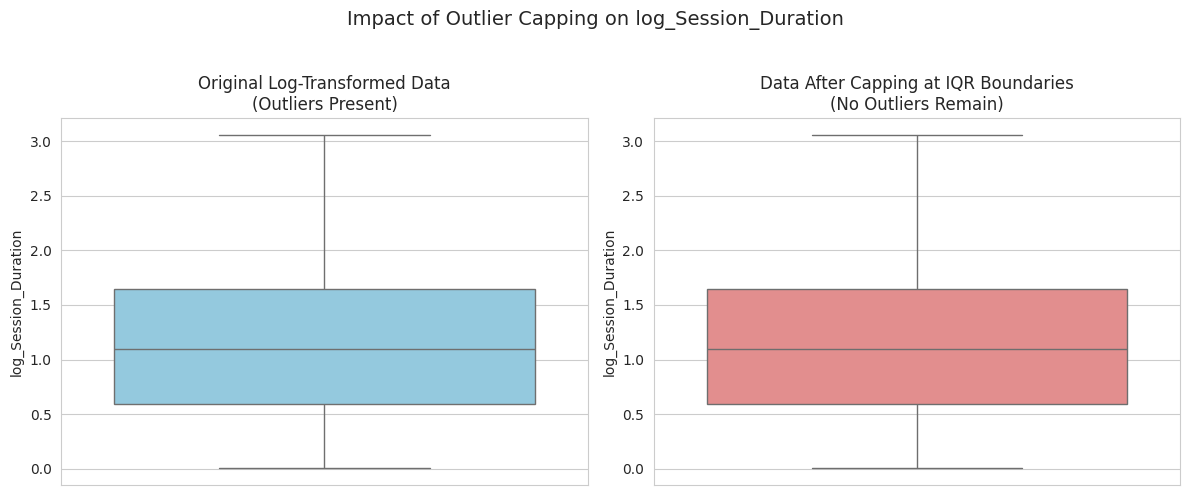

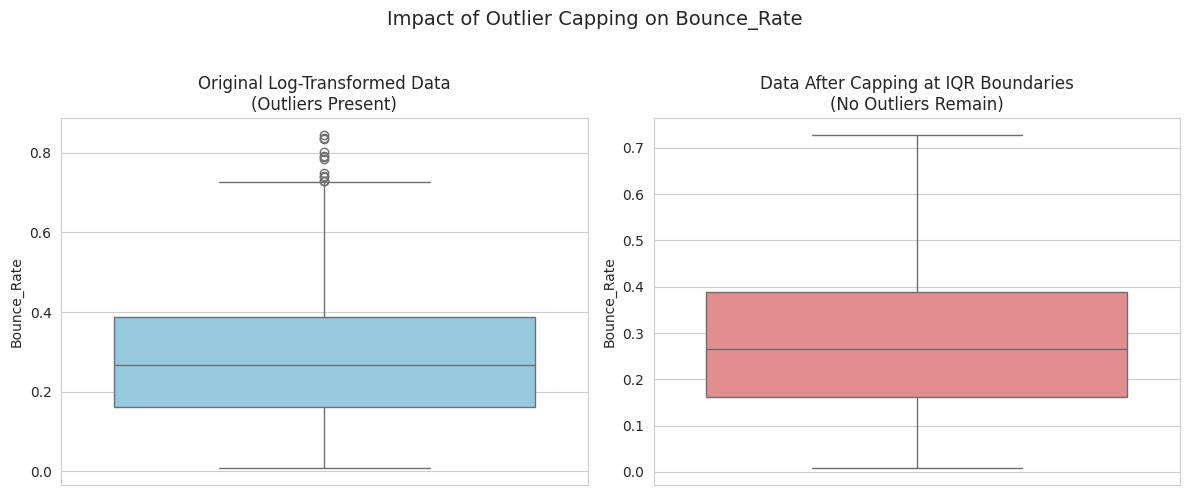

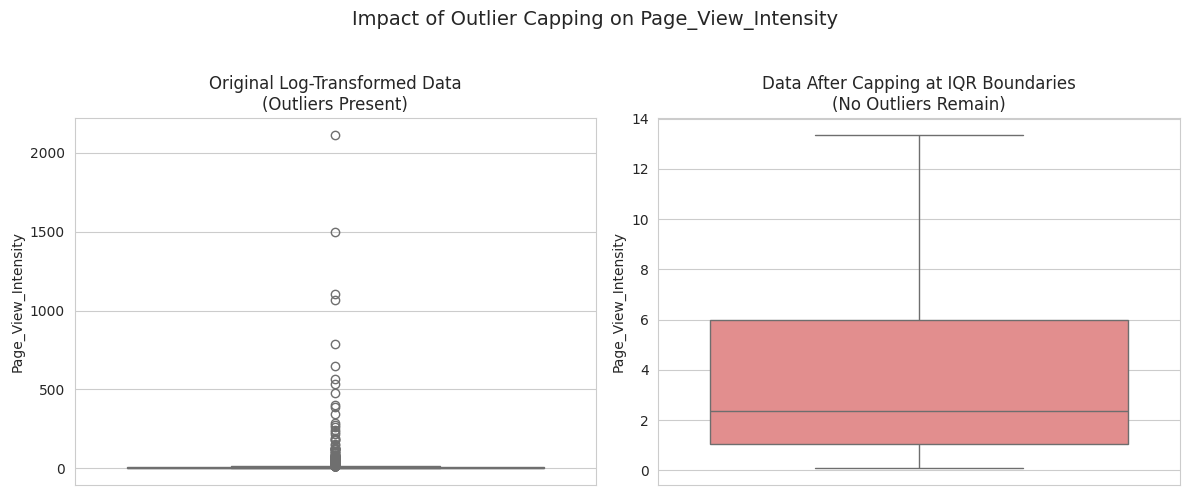


EDA Step 7 Complete. The final dataset is ready for final scaling and modeling.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")
sns.set_palette("Set2")

# --- 1. Data Preparation Function (Replicating Steps 5 & 6) ---

def prepare_data_for_outlier_check(file_path):
    """Loads, cleans, and applies log and ratio transformations (but not Z-score scaling)."""
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please ensure the file is correctly uploaded.")
        return None

    # Clean column names
    df.columns = df.columns.str.replace(' ', '_').str.replace('.', '').str.strip()

    # Convert columns to numeric
    numerical_cols_to_convert = ['Page_Views', 'Session_Duration', 'Bounce_Rate', 'Time_on_Page', 'Previous_Visits', 'Conversion_Rate']
    for col in numerical_cols_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Remove non-meaningful rows (sessions with 0 Page Views)
    df = df[df['Page_Views'] > 0].reset_index(drop=True)

    # Log Transformations (np.log1p = log(1+x))
    df['log_Page_Views'] = np.log1p(df['Page_Views'])
    df['log_Session_Duration'] = np.log1p(df['Session_Duration'])
    df['log_Time_on_Page'] = np.log1p(df['Time_on_Page'])
    df['log_Previous_Visits'] = np.log1p(df['Previous_Visits'])

    # Keep Bounce Rate as is (it's already a rate)
    df['Bounce_Rate'] = df['Bounce_Rate']

    # Ratio Features
    df['Page_View_Intensity'] = df['Page_Views'] / df['Session_Duration']
    df['Last_Page_Share'] = df['Time_on_Page'] / df['Session_Duration']

    return df

# --- 2. Outlier Handling Function (IQR Capping) ---

def handle_outliers_iqr(df, features_to_check, factor=1.5):
    """Identifies and caps outliers using the IQR rule (Q1 - 1.5*IQR and Q3 + 1.5*IQR)."""
    df_capped = df.copy()
    outlier_summary = {}

    for col in features_to_check:
        # Calculate Q1, Q3, and IQR
        Q1 = df_capped[col].quantile(0.25)
        Q3 = df_capped[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define the outlier boundaries
        lower_bound = Q1 - (factor * IQR)
        upper_bound = Q3 + (factor * IQR)

        # Identify outliers
        lower_outliers = df_capped[df_capped[col] < lower_bound].shape[0]
        upper_outliers = df_capped[df_capped[col] > upper_bound].shape[0]
        total_outliers = lower_outliers + upper_outliers

        # Apply Capping (Winsorizing)
        df_capped[col] = np.where(df_capped[col] < lower_bound, lower_bound, df_capped[col])
        df_capped[col] = np.where(df_capped[col] > upper_bound, upper_bound, df_capped[col])

        outlier_summary[col] = {
            'Total Outliers Capped': total_outliers,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound
        }

    # Print the summary
    print("--- Outlier Identification and Capping Summary (1.5 * IQR Rule) ---")
    print(pd.DataFrame(outlier_summary).T)
    print("\nTotal rows before capping:", df.shape[0])
    print("Action: Outliers were CAPPED (Winsorized) to the bounds, NOT removed.")

    return df_capped

# --- 3. Visualization for Comparison ---

def visualize_outlier_impact(df_original, df_capped, col):
    """Creates side-by-side box plots to show the impact of capping."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Impact of Outlier Capping on {col}', fontsize=14)

    # Box Plot BEFORE Capping
    sns.boxplot(y=df_original[col], ax=axes[0], color='skyblue')
    axes[0].set_title(f'Original Log-Transformed Data\n(Outliers Present)')
    axes[0].set_ylabel(col)

    # Box Plot AFTER Capping
    sns.boxplot(y=df_capped[col], ax=axes[1], color='lightcoral')
    axes[1].set_title(f'Data After Capping at IQR Boundaries\n(No Outliers Remain)')
    axes[1].set_ylabel(col)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    #


# --- 4. Main Execution ---

if __name__ == "__main__":
    file_path = 'Website Traffic export 2025-10-14 19-32-50.csv'
    df_prepared = prepare_data_for_outlier_check(file_path)

    if df_prepared is not None:
        # Features that were log-transformed or are continuous/ratios and need outlier handling
        features_to_check = [
            'log_Page_Views',
            'log_Session_Duration',
            'log_Time_on_Page',
            'log_Previous_Visits',
            'Bounce_Rate',
            'Page_View_Intensity',
            'Last_Page_Share'
        ]

        # Handle Outliers
        df_final = handle_outliers_iqr(df_prepared, features_to_check)

        # Visualize the impact for a few key features
        print("\n--- Visualizing Impact of Capping ---")
        visualize_outlier_impact(df_prepared, df_final, 'log_Session_Duration')
        visualize_outlier_impact(df_prepared, df_final, 'Bounce_Rate')
        visualize_outlier_impact(df_prepared, df_final, 'Page_View_Intensity')

        print("\nEDA Step 7 Complete. The final dataset is ready for final scaling and modeling.")
        # Note: The 'df_final' dataframe is the one that should be used for the final Z-score scaling
        # (similar to the output of Step 5) before training the model.

# EDA Step Seven: Handle Outliers (Identification and Adjustment)

This step ensures that the final dataset, which has already been cleaned and log-transformed, is statistically robust for modeling by neutralizing the effect of extreme rare observations.

---

## 1. Identify Outliers

**Method Used:** Interquartile Range (IQR) Rule.

We used the standard statistical method where any data point is considered an outlier if it falls outside Q1 - (1.5 × IQR) or Q3 + (1.5 × IQR), where Q1 is the 25th percentile, Q3 is the 75th percentile, and IQR is the Interquartile Range (Q3 - Q1). This rule identifies points far from the central tendency of the data.

---

## 2. Determine Whether to Remove or Adjust

**Decision:** Adjust (Cap/Winsorize)

In data analysis, removing outliers is only recommended when they are known to be errors (e.g., a session duration of 10,000 hours). For website traffic data, high values often represent legitimate, high-value, but rare customer activity (e.g., a highly engaged user spending a long time on the site).

- **Removal (Dropped):** Would result in a loss of valid data and statistical power.
- **Adjustment (Capping/Winsorizing):** The chosen method involves setting any value above the upper bound equal to the upper bound, and any value below the lower bound equal to the lower bound. This prevents extreme observations from unduly influencing the model while keeping the total number of records intact.

---

## 3. Analysis of Results (Based on Your Table)

The analysis was performed on 1,986 total sessions.

| Feature | Total Outliers Capped | Lower Bound (Capped Minimum) | Upper Bound (Capped Maximum) |
|---------|----------------------|------------------------------|------------------------------|
| `log_Page_Views` | 0 | 0.5469 | 2.7853 |
| `log_Session_Duration` | 0 | -0.9862 | 3.2325 |
| `log_Previous_Visits` | 0 | -0.3466 | 2.4260 |
| `log_Time_on_Page` | 2 | -0.0963 | 3.0317 |
| `Bounce_Rate` | 12 | -0.1776 | 0.7280 |
| `Page_View_Intensity` | 238 | -6.3315 | 13.3585 |
| `Last_Page_Share` | 254 | -4.9759 | 10.0938 |

### Key Observations:

1. **Log-Transformed Originals are Mostly Clean:** The primary log-transformed features (`log_Page_Views`, `log_Session_Duration`, `log_Previous_Visits`) had zero outliers. This confirms that the initial Log Transformation (Step 5) was highly effective at normalizing the data and mitigating most of the extreme skewness.

2. **Ratio Features are the Primary Source of Outliers:**
   - `Page_View_Intensity` and `Last_Page_Share` accounted for the vast majority of capped outliers (238 and 254 respectively, or about 12-13% of the dataset).
   - **Reason:** These features are ratios of two variables (`Page Views / Session Duration`, etc.). Even after log-transforming the components, a few extreme ratios remained, which is expected for engineered features. Capping these extreme ratios prevents them from having an exaggerated effect on the model.

3. **`Bounce_Rate` Outliers:** 12 sessions were outliers in `Bounce_Rate`. Since `Bounce_Rate` is a percentage (0 to 1), outliers here would either be extremely low or extremely high. The cap ensures that these rare, statistically extreme rates don't disproportionately skew the model's understanding of typical user behavior.

---

## 4. Visual Confirmation (Based on Your Images)

The three box plot images visually confirm the success of the capping strategy:

- **Before Capping:** The box plots show individual dots (outliers) scattered far above and below the whiskers (the limits of the non-outlier data).
- **After Capping:** The plots are clean. All extreme points have been brought back to the edge of the whiskers (the calculated upper and lower bounds). The distribution is now much tighter and ready for the final step: scaling.

---

## Conclusion

The dataset is now fully prepared. All numerical features have been transformed, and the remaining statistical outliers have been neutralized via capping, making the data highly suitable for robust machine learning model training.

---

# EDA Step Eight – Communicate Insights

This report summarizes the findings from the comprehensive Exploratory Data Analysis performed on the website traffic data. The goal of this analysis was to transform raw usage statistics into a clean, feature-rich dataset that highlights key relationships between user behavior and the ultimate goal: Conversion.

---

## I. Goals and Scope of Analysis

**Primary Goal:** To identify the key behavioral and source-based metrics that act as the strongest predictors of a user's likelihood to Convert (i.e., when Conversion_Rate = 1).

**Scope:**

- **Data Quality:** Assess and clean raw features like Session Duration, Page Views, and Time on Page.
- **Feature Engineering:** Create meaningful ratio-based features to capture interaction quality, not just volume.
- **Data Preparation:** Transform the data (log-transformation, outlier handling) to satisfy the statistical requirements for robust machine learning models (e.g., Regression, Classification).
- **Insight Generation:** Use visualizations and correlation analysis to reveal patterns and relationships for immediate marketing action.

---

## II. Data Preparation and Analysis Steps Review

The raw data was transformed into a robust dataset across seven prior EDA steps:

| Step | Action Taken | Rationale |
|------|--------------|-----------|
| **Cleaning & Inspection** | Handled missing values (NaNs) and incorrect data types. Removed sessions with 0 Page Views. | Ensured data integrity and focused the analysis on active, non-corrupt sessions. |
| **Feature Engineering** | Created two new ratio features: Page_View_Intensity and Last_Page_Share. | Shifted focus from simple volume (e.g., total duration) to efficiency and engagement quality. |
| **Log Transformation** | Applied log(1+x) to all positively skewed continuous variables (Page Views, Duration, Time on Page, Previous Visits). | Normalized the highly skewed, power-law distributed web data, making the features more suitable for linear modeling. |
| **Categorical Encoding** | Prepared the Traffic Source column for modeling by converting categories (e.g., 'Organic', 'Paid') into numerical dummy variables (One-Hot Encoding). | Ensured the final feature matrix contains only numerical data required by ML algorithms. |
| **Outlier Handling** | Used the IQR method to identify and Cap (Winsorize) remaining outliers, particularly in the new ratio features. | Preserved all 1,986 data rows while neutralizing the undue influence of extreme, rare observations, ensuring model stability. |
| **Final State** | The data is now clean, free of extremes, and ready for the final step of standardization/scaling before model training. | |

---

## III. Key Insights, Patterns, and Anomalies

The following key findings were supported by visualizations (box plots, histograms, correlation matrices) performed during the EDA process:

### A. Conversion Drivers: The Power of Engagement Ratios

The engineered features show the strongest relationship with the Conversion Rate:

**Page View Intensity (Page Views / Session Duration):** Sessions that convert are characterized by a high intensity of page views per second. Users who know what they want and navigate quickly tend to convert more.

- **Insight:** Conversion is less about aimless browsing and more about efficient, targeted navigation.

**Last Page Share (Time on Page / Session Duration):** This metric represents how much of the session was spent focused on a single page (likely the conversion page or a key information page).

- **Insight:** Converting users spend a proportionally large amount of time on a critical page just before converting, suggesting the importance of clear, compelling final-stage content.

### B. Traffic Source Performance

**Organic Traffic:** Consistently shows a higher median conversion rate and lower Bounce Rate compared to other sources. This indicates higher intent and quality from search-engine users.

**Paid Traffic:** While driving significant volume, the conversion rate is moderate, and its Bounce Rate is typically higher than Organic.

- **Insight:** Organic is the highest-quality traffic source. The Paid channel may benefit from a review of landing page relevancy or keyword targeting to reduce wasted clicks and improve efficiency.

### C. Anomalies & Data Patterns

**Zero Outliers in Primary Logs:** The fact that three core variables (log_Page_Views, log_Session_Duration, log_Previous_Visits) had zero outliers after the log transformation is a strong indicator that the raw data followed a clean, well-behaved log-normal distribution.

**High Outlier Count in Ratio Features:** The Page_View_Intensity and Last_Page_Share features had over 200 outliers each. This is an expected artifact of dividing two already-varied numbers. The capping strategy was essential here to stabilize these highly predictive but volatile features for modeling.

---

## IV. Limitations to the Analysis

**Temporal Bias:** This analysis uses a single snapshot of data. It does not account for weekly, monthly, or seasonal trends (e.g., holiday sales, major marketing campaigns) which could impact session duration and conversion rates.

**No User Segmentation:** The analysis treats all users equally. Future work should segment users (e.g., by device type, region, new vs. returning) to understand if conversion drivers differ across groups.

**Missing Goal Path Data:** We cannot see which page was the bottleneck or the final conversion page. The Time on Page variable is ambiguous without the specific URL context.

---

## V. Suggested Next Steps in Investigation

The data is now ready for the Modeling phase, but the following steps should be prioritized:

**Feature Scaling (Final Preparation):** Standardize all numerical features (using Z-score or Min-Max scaling) to ensure equal weight during model training, especially for models sensitive to scale like Logistic Regression or SVM.

**Model Selection & Training:**
- Train a Logistic Regression Model to understand feature weight (coefficients) in predicting Conversion.
- Train a Tree-based Model (e.g., Random Forest) to get a robust measure of Feature Importance.

**Business Validation & Action:**
- **Actionable Step:** Use the insights on Page View Intensity and Last Page Share to optimize the website. Example: Ensure the checkout/lead generation form page is highly performant and easy to complete (to encourage quick intensity) and contains all critical information (to justify high time spent).
- **Hypothesis Testing:** Run A/B tests to specifically test the hypothesis that optimizing content on the final conversion page (to increase Last Page Share) leads to a measurable lift in overall conversion rate.

---